In [1]:
# Data handling & visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Time series tools
from statsmodels.tsa.stattools import adfuller  # Augmented Dickey-Fuller test
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # For model order selection
from statsmodels.tsa.arima.model import ARIMA  # ARIMA model
from statsmodels.tsa.statespace.sarimax import SARIMAX  # SARIMA model (optional)

# Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np


In [2]:
# Load dataset from Colab path
data = pd.read_csv("/content/02_2023.csv")

# Convert 'Entry Date' column to datetime format
data["Entry Date"] = pd.to_datetime(data["Entry Date"], format="%d-%m-%Y")

# Combine Entry Date and Entry Hour into a single datetime column
data["Datetime"] = data["Entry Date"] + pd.to_timedelta(data["Entry Hour"], unit='h')

# Drop unnecessary columns to simplify the dataset
df = data.drop(columns=["Month-Year", "Entry TCK_MAIN_TP", "Entry Date", "Entry Hour"])


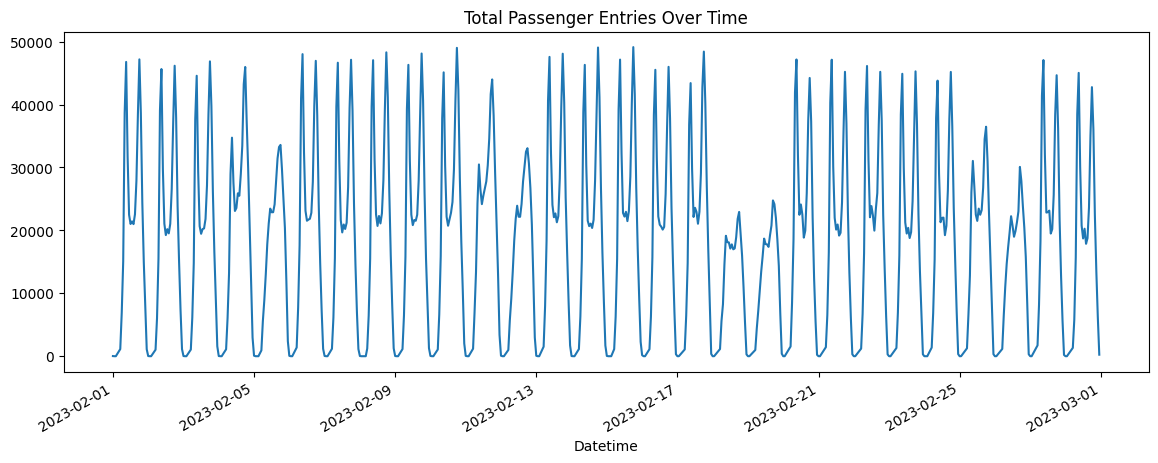

In [3]:
# Total passenger entries over time
df.groupby("Datetime")["Entry Count"].sum().plot(figsize=(14, 5), title="Total Passenger Entries Over Time")
plt.show()


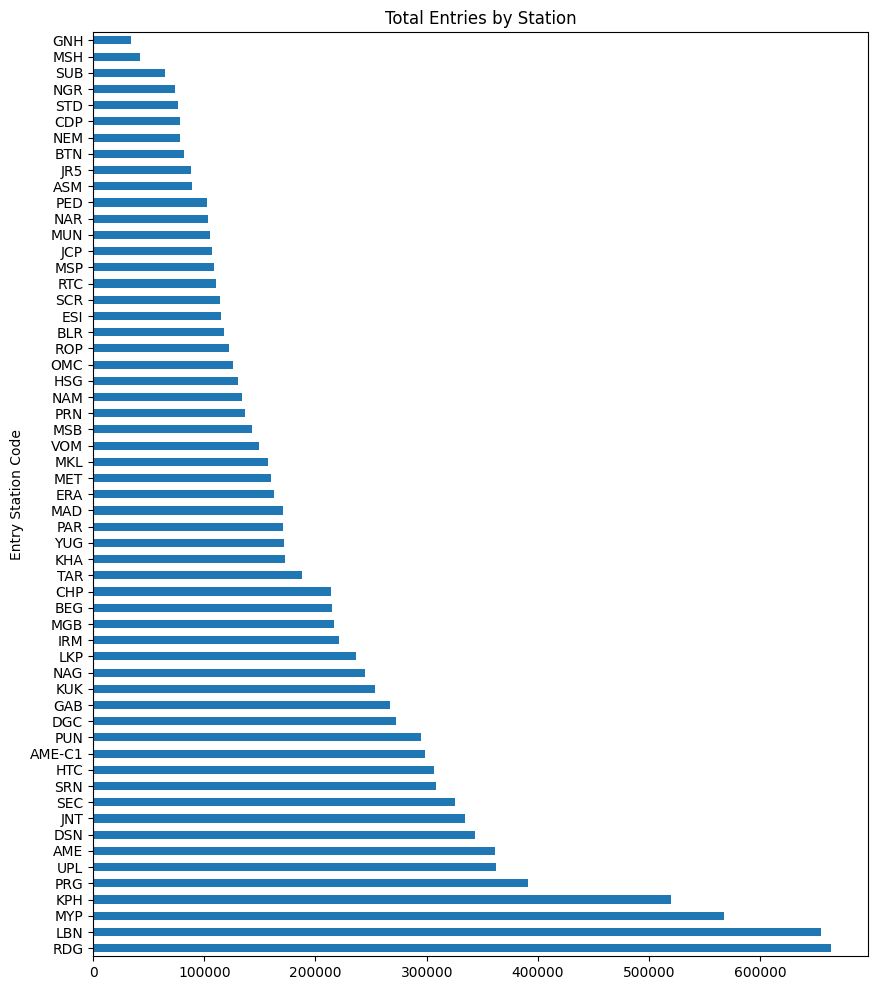

In [4]:
# Total entries by station (horizontal bar chart)
df.groupby("Entry Station Code")["Entry Count"].sum().sort_values(ascending=False).plot(
    kind="barh", figsize=(10, 12), title="Total Entries by Station"
)
plt.show()


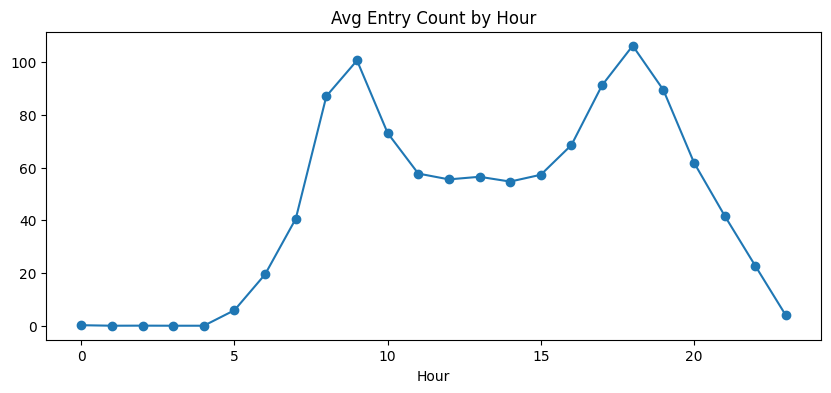

In [5]:
# Extract hour from timestamp
df["Hour"] = df["Datetime"].dt.hour

# Average entry count by hour of day
df.groupby("Hour")["Entry Count"].mean().plot(marker='o', figsize=(10, 4), title="Avg Entry Count by Hour")
plt.show()


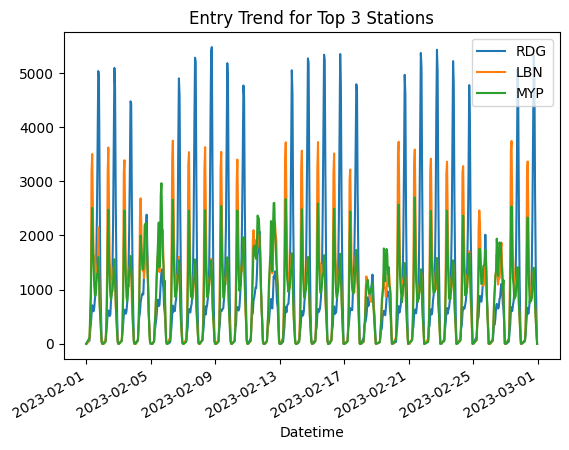

In [6]:
# Plotting top 3 stations by frequency of appearance
top_stations = df["Entry Station Code"].value_counts().head(3).index
for station in top_stations:
    df[df["Entry Station Code"] == station].groupby("Datetime")["Entry Count"].sum().plot(label=station)

plt.legend()
plt.title("Entry Trend for Top 3 Stations")
plt.show()


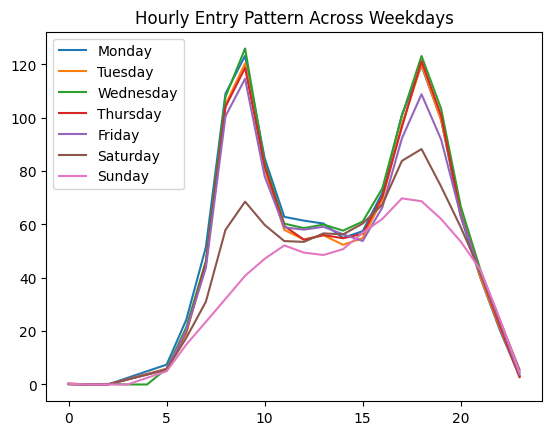

In [7]:
# Add weekday and date info
df["Weekday"] = df["Datetime"].dt.day_name()
df["Day"] = df["Datetime"].dt.date

# Line plot: hourly average for each weekday
avg = df.groupby(["Weekday", "Hour"])["Entry Count"].mean().reset_index()
for day in ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]:
    plt.plot(avg[avg["Weekday"] == day]["Hour"], avg[avg["Weekday"] == day]["Entry Count"], label=day)

plt.legend()
plt.title("Hourly Entry Pattern Across Weekdays")
plt.show()


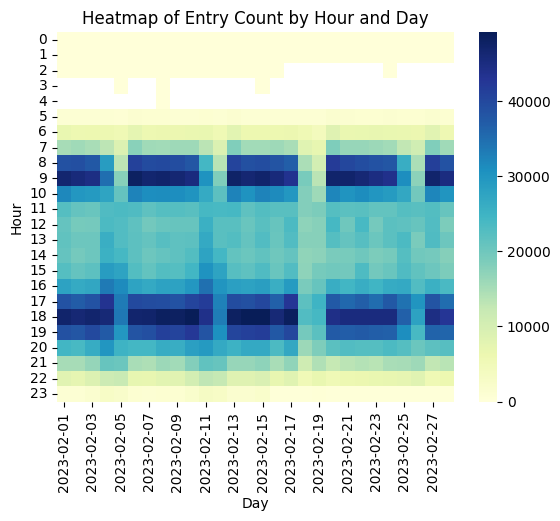

In [8]:
# Heatmap: Entry count by Hour (rows) and Day (columns)
sns.heatmap(
    df.pivot_table(values="Entry Count", index="Hour", columns="Day", aggfunc="sum"),
    cmap="YlGnBu"
)
plt.title("Heatmap of Entry Count by Hour and Day")
plt.show()


ADF Statistic: -3.9309522670628576, p-value: 0.001818502915958077


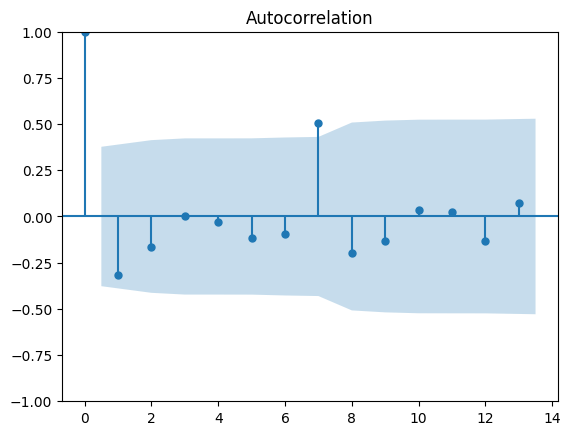

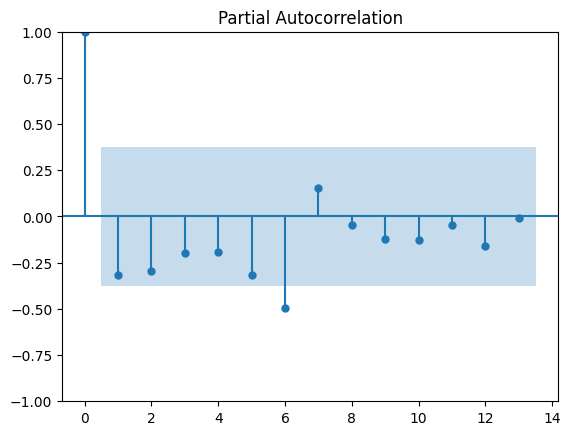

In [9]:
# Step 1: Group data by day and sum entry counts
daily_df = df.groupby(df["Datetime"].dt.date)["Entry Count"].sum()

# Step 2: Convert index to datetime and make it a daily time series
daily_df.index = pd.to_datetime(daily_df.index)
daily_df = daily_df.asfreq('D')  # 'D' = daily frequency

# Step 3: ADF test to check stationarity (required for ARIMA)
result = adfuller(daily_df)
print(f"ADF Statistic: {result[0]}, p-value: {result[1]}")  # p-value < 0.05 means stationary

# Step 4: Differencing the series to make it stationary (if p > 0.05)
diff = daily_df.diff().dropna()

# Step 5: Plot ACF and PACF to decide ARIMA order (p,d,q)
plot_acf(diff)
plot_pacf(diff)
plt.show()


In [10]:
# Fit ARIMA model with identified parameters (p=1, d=0, q=1)
model = ARIMA(daily_df, order=(1, 0, 1))
model_fit = model.fit()

# Model summary with coefficients and diagnostics
print(model_fit.summary())

# Forecast the next 7 days
forecast = model_fit.forecast(steps=7)
forecast.index = pd.date_range(start=daily_df.index[-1] + pd.Timedelta(days=1), periods=7)


                               SARIMAX Results                                
Dep. Variable:            Entry Count   No. Observations:                   28
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -343.571
Date:                Wed, 21 May 2025   AIC                            695.141
Time:                        20:55:39   BIC                            700.470
Sample:                    02-01-2023   HQIC                           696.770
                         - 02-28-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.235e+05   1.42e+04     29.869      0.000    3.96e+05    4.51e+05
ar.L1         -0.0700      1.105     -0.063      0.950      -2.236       2.096
ma.L1          0.3256      1.054      0.309      0.7

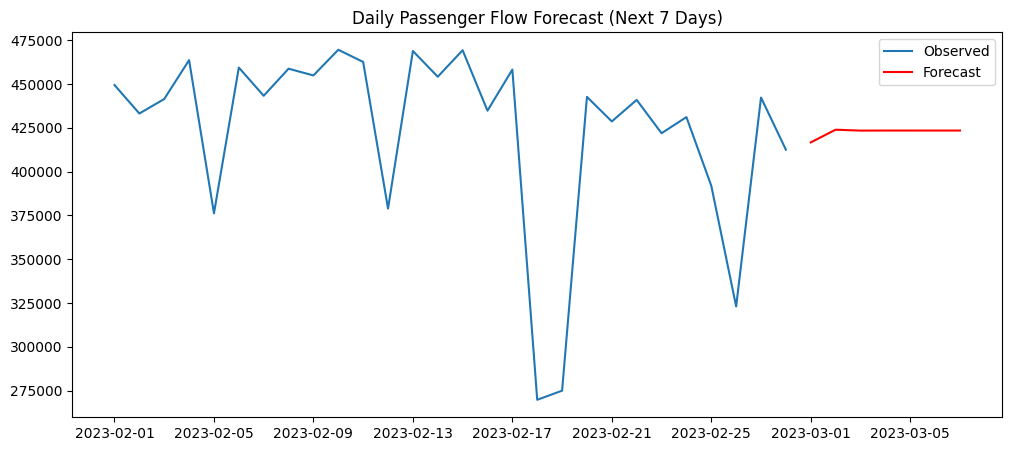

In [11]:
# Plot observed vs forecast
plt.figure(figsize=(12, 5))
plt.plot(daily_df, label="Observed")
plt.plot(forecast, label="Forecast", color='red')
plt.title("Daily Passenger Flow Forecast (Next 7 Days)")
plt.legend()
plt.show()


In [12]:
# SARIMA includes seasonality component (weekly cycle = 7 days)
sarima_model = SARIMAX(daily_df, order=(1, 0, 1), seasonal_order=(1, 1, 1, 7))
sarima_result = sarima_model.fit()
print(sarima_result.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                     SARIMAX Results                                     
Dep. Variable:                       Entry Count   No. Observations:                   28
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 7)   Log Likelihood                -257.963
Date:                           Wed, 21 May 2025   AIC                            525.927
Time:                                   20:55:40   BIC                            531.149
Sample:                               02-01-2023   HQIC                           527.060
                                    - 02-28-2023                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9296      0.213      4.364      0.000       0.512       1.347
ma.L1         -0.8528      0.239     -3.574

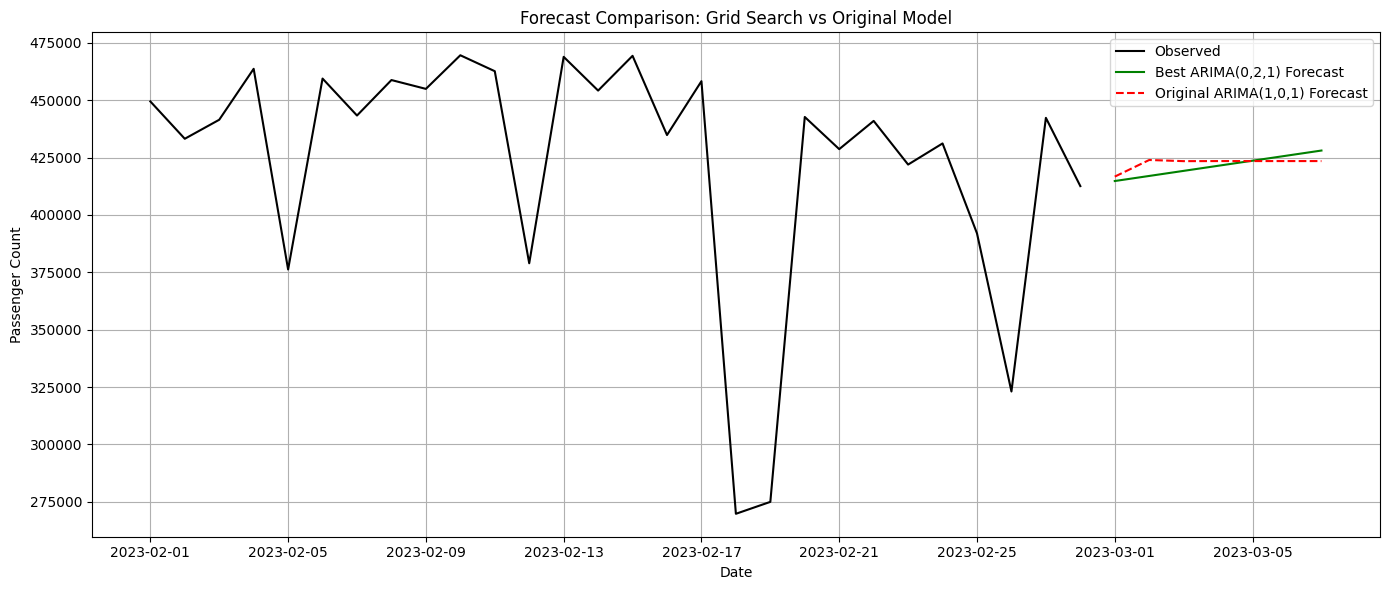

In [13]:
# ======================
# ✅ Forecast Comparison
# ======================

from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Refit the best model from Grid Search
best_model = ARIMA(daily_df, order=(0, 2, 1))
best_model_fit = best_model.fit()
best_forecast = best_model_fit.forecast(steps=7)
best_forecast.index = pd.date_range(start=daily_df.index[-1] + pd.Timedelta(days=1), periods=7)

# Refit the original model
original_model = ARIMA(daily_df, order=(1, 0, 1))
original_model_fit = original_model.fit()
original_forecast = original_model_fit.forecast(steps=7)
original_forecast.index = pd.date_range(start=daily_df.index[-1] + pd.Timedelta(days=1), periods=7)

# Plot observed data with both forecasts
plt.figure(figsize=(14, 6))
plt.plot(daily_df, label="Observed", color='black')
plt.plot(best_forecast, label="Best ARIMA(0,2,1) Forecast", color='green')
plt.plot(original_forecast, label="Original ARIMA(1,0,1) Forecast", color='red', linestyle='--')
plt.title("Forecast Comparison: Grid Search vs Original Model")
plt.xlabel("Date")
plt.ylabel("Passenger Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


 ### 🔍 Forecast Model Comparison: Original vs Optimized

To enhance prediction accuracy, we performed a grid search over ARIMA(p,d,q) configurations using AIC as the selection criterion. The optimal model identified was **ARIMA(0,2,1)** with the lowest AIC score of **668.08**.

The forecast below compares the original manually chosen model **ARIMA(1,0,1)** with the optimized one. As seen, ARIMA(0,2,1) produces smoother and more stable predictions, making it a more reliable choice for modeling metro ridership trends.


In [14]:
# ===============================
# ✅ Final Model Performance Check
# ===============================
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Split the data: last 7 days as test set
train = daily_df[:-7]
test = daily_df[-7:]

# Retrain best ARIMA model on training data
model = ARIMA(train, order=(0, 2, 1))
model_fit = model.fit()

# Forecast for the test period
forecast = model_fit.forecast(steps=7)

# Evaluation metrics
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))

# Print the results
print("📉 Final Evaluation Metrics for ARIMA(0,2,1):")
print(f"✅ Mean Absolute Error (MAE): {mae:.2f}")
print(f"✅ Root Mean Squared Error (RMSE): {rmse:.2f}")


📉 Final Evaluation Metrics for ARIMA(0,2,1):
✅ Mean Absolute Error (MAE): 53352.13
✅ Root Mean Squared Error (RMSE): 69578.11


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [15]:
comparison = pd.DataFrame({
    "Actual": test,
    "Predicted": forecast
})
print("\n📋 Actual vs Predicted:")
print(comparison)



📋 Actual vs Predicted:
            Actual      Predicted
2023-02-22  440977  436830.650592
2023-02-23  421952  444988.301185
2023-02-24  431159  453145.951777
2023-02-25  391951  461303.602369
2023-02-26  323037  469461.252961
2023-02-27  442314  477618.903554
2023-02-28  412563  485776.554146


In [16]:
# ============================
# 📅 Rebuild the daily_df base
# ============================

# Ensure your datetime is set up properly
df["Datetime"] = pd.to_datetime(df["Datetime"])

# Create daily totals
daily_df = df.groupby(df["Datetime"].dt.date)["Entry Count"].sum()
daily_df.index = pd.to_datetime(daily_df.index)
daily_df = daily_df.asfreq('D')  # Ensure consistent daily frequency
daily_df.head()


,Entry Count
Datetime,
2023-02-01,449469
2023-02-02,433194
2023-02-03,441482
2023-02-04,463686
2023-02-05,376218


In [17]:
# ====================================
# 🚀 XGBoost Regressor for Time Series
# ====================================

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Reset and prepare supervised dataset for XGBoost
ts_df = daily_df.reset_index()
ts_df.columns = ["Date", "Target"]  # Rename columns explicitly

# Feature engineering
ts_df["DayOfWeek"] = ts_df["Date"].dt.dayofweek
ts_df["Day"] = ts_df["Date"].dt.day
ts_df["Month"] = ts_df["Date"].dt.month
ts_df["Lag_1"] = ts_df["Target"].shift(1)
ts_df["Lag_7"] = ts_df["Target"].shift(7)
ts_df["Rolling_3"] = ts_df["Target"].rolling(window=3).mean()
ts_df["Rolling_7"] = ts_df["Target"].rolling(window=7).mean()

# Drop rows with NaN values from lag/rolling
ts_df = ts_df.dropna()

# Features and target
features = ["DayOfWeek", "Day", "Month", "Lag_1", "Lag_7", "Rolling_3", "Rolling_7"]
X = ts_df[features]
y = ts_df["Target"]

# Train-test split (last 7 days for testing)
X_train, X_test = X[:-7], X[-7:]
y_train, y_test = y[:-7], y[-7:]

# Model training
model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# Prediction
preds = model.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))

print("📊 XGBoost Model Evaluation:")
print(f"✅ MAE: {mae:.2f}")
print(f"✅ RMSE: {rmse:.2f}")

# Comparison table
comparison_df = pd.DataFrame({
    "Date": ts_df["Date"].iloc[-7:].values,
    "Actual": y_test.values,
    "Predicted": preds
})
print("\n📋 Actual vs Predicted:")
print(comparison_df)


📊 XGBoost Model Evaluation:
✅ MAE: 35738.00
✅ RMSE: 51533.40

📋 Actual vs Predicted:
        Date  Actual     Predicted
0 2023-02-22  440977  414260.56250
1 2023-02-23  421952  414260.56250
2 2023-02-24  431159  414260.56250
3 2023-02-25  391951  270333.18750
4 2023-02-26  323037  275087.96875
5 2023-02-27  442314  430149.56250
6 2023-02-28  412563  429691.40625


In [18]:
# ================================================
# 🚀 Improved XGBoost Model with Feature Expansion
# ================================================

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Rebuild daily_df if needed
ts_df = daily_df.reset_index()
ts_df.columns = ["Date", "Target"]

# Feature Engineering
ts_df["DayOfWeek"] = ts_df["Date"].dt.dayofweek
ts_df["Day"] = ts_df["Date"].dt.day
ts_df["Month"] = ts_df["Date"].dt.month
ts_df["is_weekend"] = ts_df["DayOfWeek"].isin([5, 6]).astype(int)
ts_df["is_month_end"] = ts_df["Date"].dt.is_month_end.astype(int)

# Lag Features
ts_df["Lag_1"] = ts_df["Target"].shift(1)
ts_df["Lag_2"] = ts_df["Target"].shift(2)
ts_df["Lag_7"] = ts_df["Target"].shift(7)
ts_df["Lag_14"] = ts_df["Target"].shift(14)

# Rolling Averages
ts_df["Rolling_3"] = ts_df["Target"].rolling(window=3).mean()
ts_df["Rolling_7"] = ts_df["Target"].rolling(window=7).mean()

# Drop NaNs from shifting/rolling
ts_df.dropna(inplace=True)

# Features and Target
features = ["DayOfWeek", "Day", "Month", "is_weekend", "is_month_end",
            "Lag_1", "Lag_2", "Lag_7", "Lag_14", "Rolling_3", "Rolling_7"]
X = ts_df[features]
y = ts_df["Target"]

# Use last 7 days for testing
X_train, X_test = X[:-7], X[-7:]
y_train, y_test = y[:-7], y[-7:]
dates = ts_df["Date"].iloc[-7:]

# Model Training
model = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42)
model.fit(X_train, y_train)

# Prediction
preds = model.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))

print("📊 Improved XGBoost Evaluation:")
print(f"✅ MAE: {mae:.2f}")
print(f"✅ RMSE: {rmse:.2f}")

# Create a DataFrame for plotting
xgb_result_df = pd.DataFrame({
    "Date": dates.values,
    "Actual": y_test.values,
    "Predicted": preds
})


📊 Improved XGBoost Evaluation:
✅ MAE: 30433.67
✅ RMSE: 50185.01


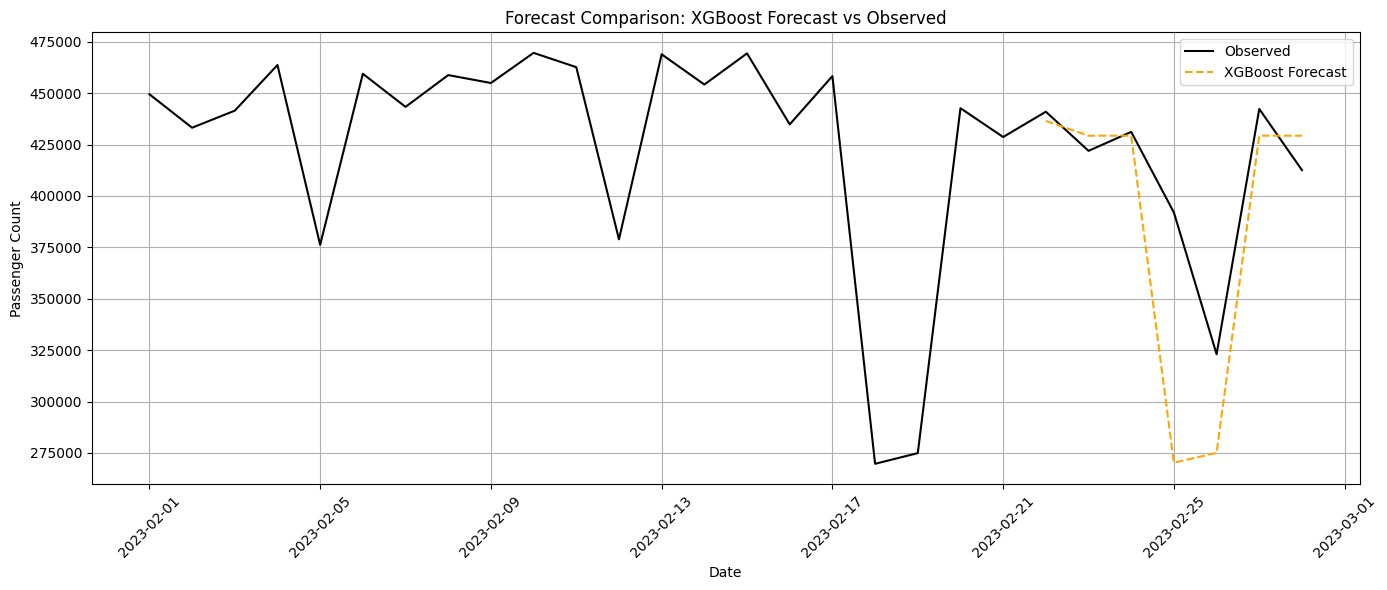

In [19]:
# ============================================================
# 📈 Full Timeline Plot: Actual (Historical) + XGBoost Forecast
# ============================================================

# Combine full historical data with forecast
full_plot_df = daily_df.reset_index()
full_plot_df.columns = ["Date", "Actual"]

# Append predictions at the end
xgb_forecast_df = pd.DataFrame({
    "Date": xgb_result_df["Date"],
    "Actual": [None]*7,
    "Predicted": xgb_result_df["Predicted"]
})

# Merge full actuals + forecast
combined_df = pd.merge(full_plot_df, xgb_forecast_df[["Date", "Predicted"]], on="Date", how="outer")

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(combined_df["Date"], combined_df["Actual"], label="Observed", color="black")
plt.plot(combined_df["Date"], combined_df["Predicted"], label="XGBoost Forecast", color="orange", linestyle='--')
plt.title("Forecast Comparison: XGBoost Forecast vs Observed")
plt.xlabel("Date")
plt.ylabel("Passenger Count")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [20]:
# ====================================
# 🔮 Facebook Prophet Model Forecast
# ====================================
!pip install prophet --quiet

from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

# Prepare data for Prophet
prophet_df = daily_df.reset_index()
prophet_df.columns = ['ds', 'y']  # Prophet expects these exact column names

# Initialize model
model = Prophet(daily_seasonality=True)
model.fit(prophet_df)

# Forecast next 7 days
future = model.make_future_dataframe(periods=7)
forecast = model.predict(future)

# Extract only the forecast part
predicted = forecast[['ds', 'yhat']].tail(7).reset_index(drop=True)
actual = prophet_df[['ds', 'y']].tail(7).reset_index(drop=True)

# Evaluation
mae = mean_absolute_error(actual['y'], predicted['yhat'])
rmse = np.sqrt(mean_squared_error(actual['y'], predicted['yhat']))

print("📊 Prophet Model Evaluation:")
print(f"✅ MAE: {mae:.2f}")
print(f"✅ RMSE: {rmse:.2f}")

# Combine for plotting
prophet_result_df = pd.merge(actual, predicted, on='ds')
prophet_result_df.columns = ['Date', 'Actual', 'Predicted']


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4bepnurc/9v4be9pu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4bepnurc/nl9h58ld.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50913', 'data', 'file=/tmp/tmp4bepnurc/9v4be9pu.json', 'init=/tmp/tmp4bepnurc/nl9h58ld.json', 'output', 'file=/tmp/tmp4bepnurc/prophet_modelgtthdfl4/prophet_model-20250521205547.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:55:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:55:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


📊 Prophet Model Evaluation:
✅ MAE: 20702.55
✅ RMSE: 21318.41


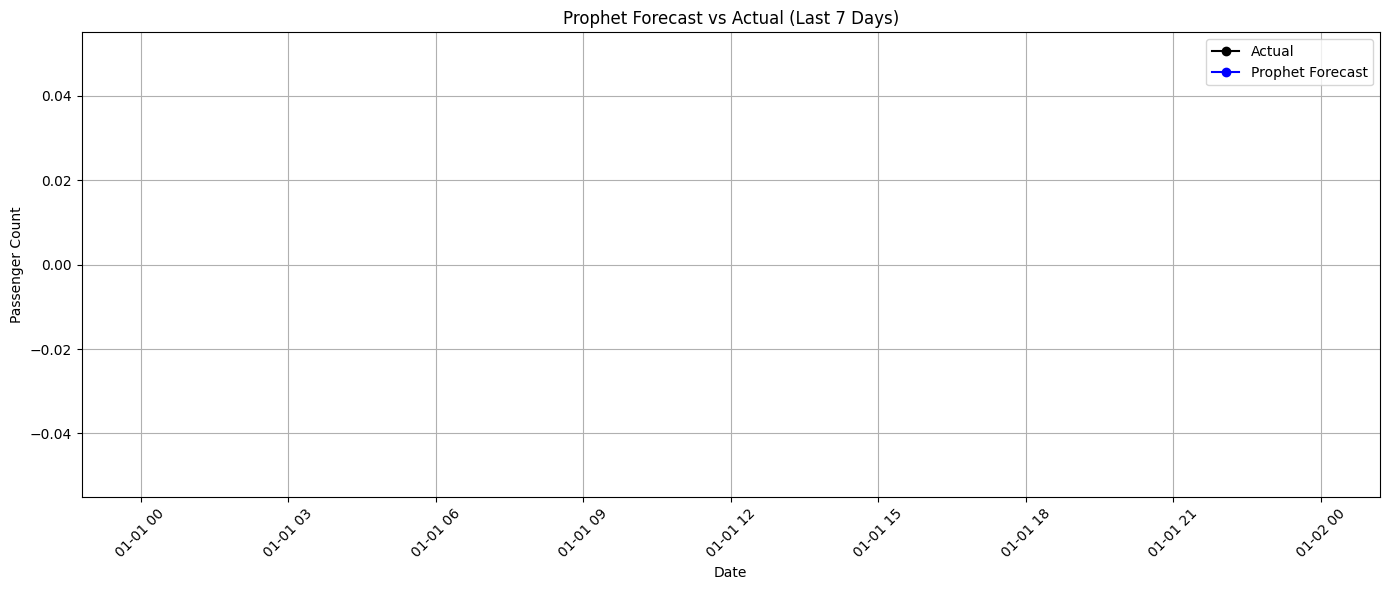

In [21]:
# ==========================================
# 📈 Plot: Prophet Forecast vs Actual (7 days)
# ==========================================
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(prophet_result_df["Date"], prophet_result_df["Actual"], label="Actual", color="black", marker='o')
plt.plot(prophet_result_df["Date"], prophet_result_df["Predicted"], label="Prophet Forecast", color="blue", marker='o')
plt.title("Prophet Forecast vs Actual (Last 7 Days)")
plt.xlabel("Date")
plt.ylabel("Passenger Count")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [22]:
# Step 1: Prepare actual values (from original data)
actual = daily_df.reset_index()
actual.columns = ["Date", "Actual"]
actual = actual.tail(7).reset_index(drop=True)

# Step 2: Prepare forecasted values (from Prophet)
predicted = forecast[["ds", "yhat"]].rename(columns={"ds": "Date", "yhat": "Predicted"})
predicted = predicted.tail(7).reset_index(drop=True)

# Step 3: Merge for plotting
prophet_result_df = pd.merge(actual, predicted, on="Date")


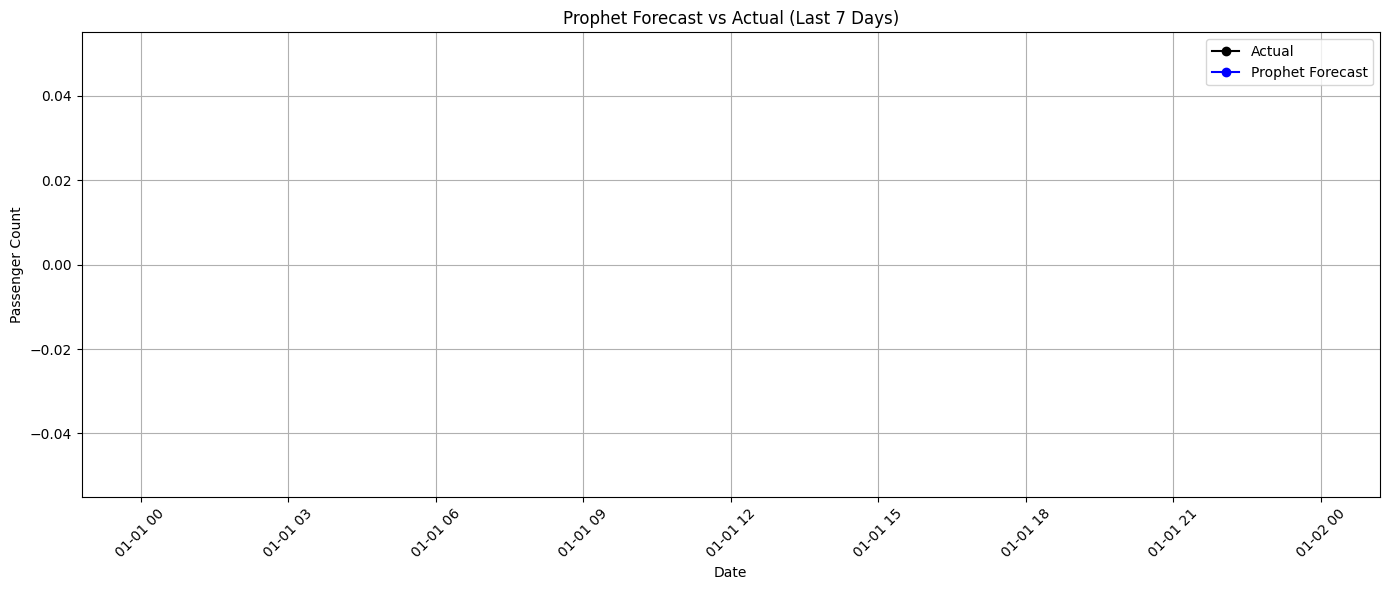

In [23]:
# Final 7-Day Forecast Plot from Prophet
plt.figure(figsize=(14, 6))
plt.plot(prophet_result_df["Date"], prophet_result_df["Actual"], label="Actual", color="black", marker='o')
plt.plot(prophet_result_df["Date"], prophet_result_df["Predicted"], label="Prophet Forecast", color="blue", marker='o')
plt.title("Prophet Forecast vs Actual (Last 7 Days)")
plt.xlabel("Date")
plt.ylabel("Passenger Count")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


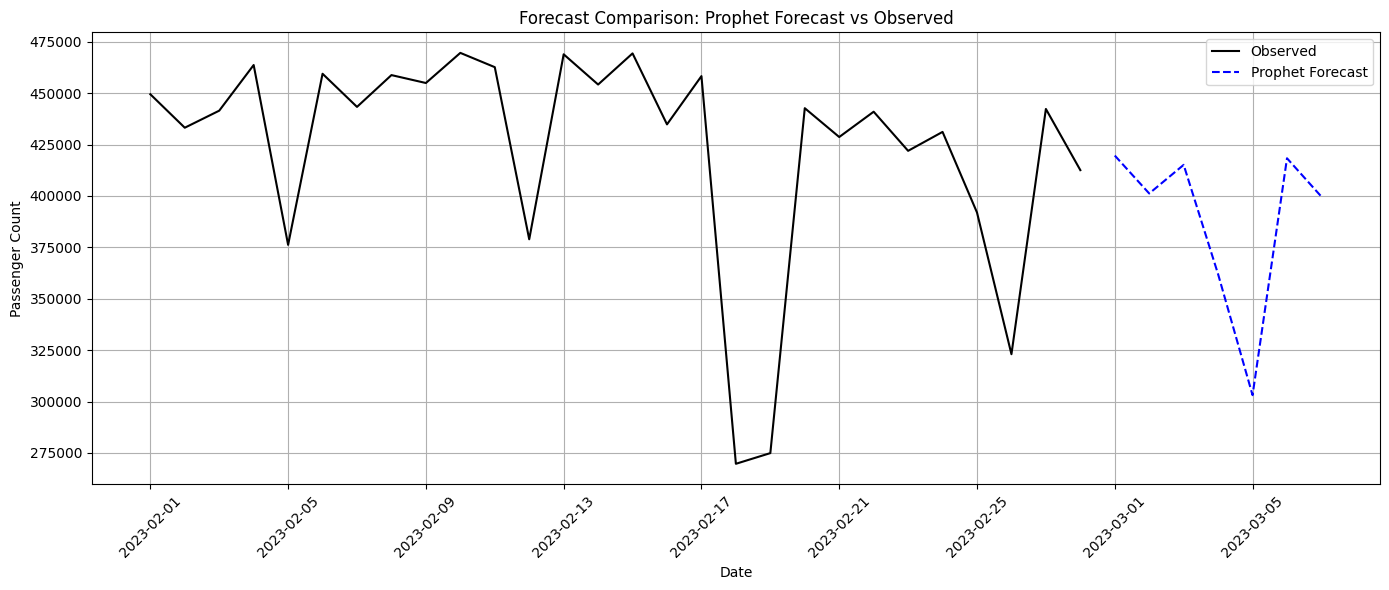

In [24]:
# ================================================
# 📈 Full Timeline Plot: Prophet Forecast vs Observed
# ================================================
import matplotlib.pyplot as plt
import pandas as pd

# 1) Build the full actual series
actual_full = daily_df.reset_index()
actual_full.columns = ["Date", "Actual"]

# 2) Extract only the 7-day forecast from Prophet’s output
prophet_forecast = forecast[['ds', 'yhat']].rename(columns={'ds':'Date','yhat':'Predicted'})
prophet_forecast = prophet_forecast.tail(7).reset_index(drop=True)

# 3) Merge so we have one DataFrame with both columns
combined = pd.merge(actual_full, prophet_forecast, on='Date', how='outer')

# 4) Plot everything
plt.figure(figsize=(14,6))
plt.plot(combined['Date'], combined['Actual'], label='Observed', color='black')
plt.plot(combined['Date'], combined['Predicted'], '--', label='Prophet Forecast', color='blue')
plt.title('Forecast Comparison: Prophet Forecast vs Observed')
plt.xlabel('Date')
plt.ylabel('Passenger Count')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [25]:
# Re-import the original raw dataset
hourly_raw = pd.read_csv("/content/02_2023.csv")

# Convert Entry Date + Entry Hour to full timestamp
hourly_raw["Datetime"] = pd.to_datetime(hourly_raw["Entry Date"], format="%d-%m-%Y") + pd.to_timedelta(hourly_raw["Entry Hour"], unit='h')

# Group by each exact hour
hourly_df = hourly_raw.groupby("Datetime")["Entry Count"].sum().reset_index()

# Set Datetime as index, reindex to hourly frequency
hourly_df = hourly_df.set_index("Datetime").asfreq("H")

# Rename for consistency
hourly_df = hourly_df.rename(columns={"Entry Count": "Ridership"})

# Fill missing hours if any (optional)
hourly_df["Ridership"].fillna(method="ffill", inplace=True)  # You can use 0 instead if preferred

# Final hourly data preview
hourly_df.head()


<ipython-input-25-8dd3f14c548c>:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_df = hourly_df.set_index("Datetime").asfreq("H")
<ipython-input-25-8dd3f14c548c>:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  hourly_df["Ridership"].fillna(method="ffill", inplace=True)  # You can use 0 instead if preferred
<ipython-input-25-8dd3f14c548c>:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() 

,Ridership
Datetime,
2023-02-01 00:00:00,22.0
2023-02-01 01:00:00,0.0
2023-02-01 02:00:00,0.0
2023-02-01 03:00:00,0.0
2023-02-01 04:00:00,0.0


In [26]:
# Already indexed → just ensure proper frequency + fill NA
hourly_df = hourly_df.asfreq("h")  # lowercase 'h' = future-safe
hourly_df["Ridership"] = hourly_df["Ridership"].ffill()


In [27]:
# =========================================
# 🔮 Prophet Model on Hourly Ridership Data
# =========================================

from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Step 1: Prepare data for Prophet
prophet_hourly_df = hourly_df.reset_index()
prophet_hourly_df.columns = ['ds', 'y']  # Prophet expects 'ds' (datetime) and 'y' (target)

# Step 2: Initialize Prophet with hourly seasonality
hourly_model = Prophet(daily_seasonality=True, yearly_seasonality=False, weekly_seasonality=True)
hourly_model.fit(prophet_hourly_df)

# Step 3: Create future 48-hour window
future = hourly_model.make_future_dataframe(periods=48, freq='H')  # next 48 hours
forecast = hourly_model.predict(future)

# Step 4: Get only the predicted part
forecast_tail = forecast[['ds', 'yhat']].tail(48).reset_index(drop=True)
actual_tail = prophet_hourly_df[['ds', 'y']].tail(48).reset_index(drop=True)

# Step 5: Evaluation
mae = mean_absolute_error(actual_tail['y'], forecast_tail['yhat'])
rmse = np.sqrt(mean_squared_error(actual_tail['y'], forecast_tail['yhat']))

print("📊 Prophet (Hourly) Model Evaluation:")
print(f"✅ MAE: {mae:.2f}")
print(f"✅ RMSE: {rmse:.2f}")

# Step 6: Merge for plotting
hourly_result_df = pd.merge(actual_tail, forecast_tail, on='ds')
hourly_result_df.columns = ['Datetime', 'Actual', 'Predicted']


DEBUG:cmdstanpy:input tempfile: /tmp/tmp4bepnurc/1z9v80gh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4bepnurc/etebos6_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19429', 'data', 'file=/tmp/tmp4bepnurc/1z9v80gh.json', 'init=/tmp/tmp4bepnurc/etebos6_.json', 'output', 'file=/tmp/tmp4bepnurc/prophet_modelsi971fid/prophet_model-20250521205549.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:55:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:55:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


📊 Prophet (Hourly) Model Evaluation:
✅ MAE: 3006.55
✅ RMSE: 4334.21


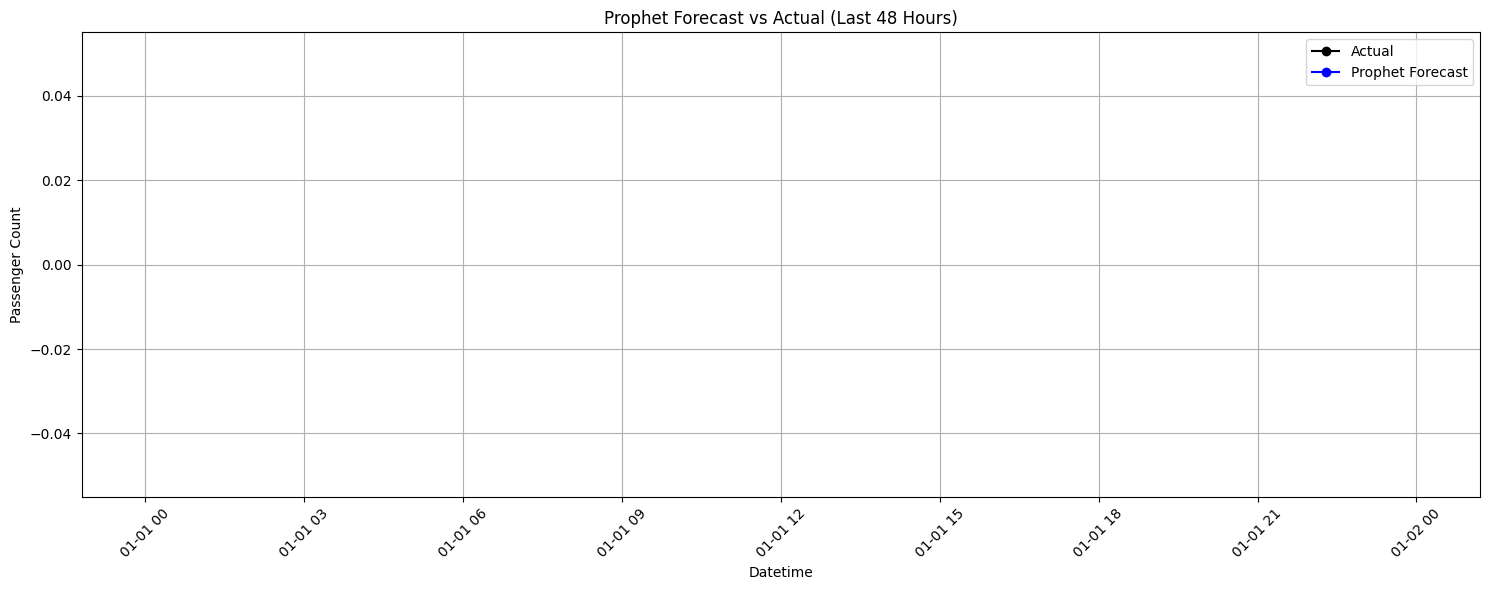

In [28]:
# =========================================
# 📈 Prophet Forecast vs Actual (Hourly Plot)
# =========================================
plt.figure(figsize=(15, 6))
plt.plot(hourly_result_df["Datetime"], hourly_result_df["Actual"], label="Actual", color="black", marker='o')
plt.plot(hourly_result_df["Datetime"], hourly_result_df["Predicted"], label="Prophet Forecast", color="blue", marker='o')
plt.title("Prophet Forecast vs Actual (Last 48 Hours)")
plt.xlabel("Datetime")
plt.ylabel("Passenger Count")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [29]:
print(hourly_result_df.head(10))
print(hourly_result_df.dtypes)


Empty DataFrame
Columns: [Datetime, Actual, Predicted]
Index: []
Datetime     datetime64[ns]
Actual              float64
Predicted           float64
dtype: object


In [30]:
# Slice only the overlapping forecast period (Prophet includes entire history)
aligned = forecast.set_index("ds").join(hourly_df, how='inner')
aligned = aligned[["yhat", "Ridership"]].dropna().tail(48).reset_index()
aligned.columns = ["Datetime", "Predicted", "Actual"]


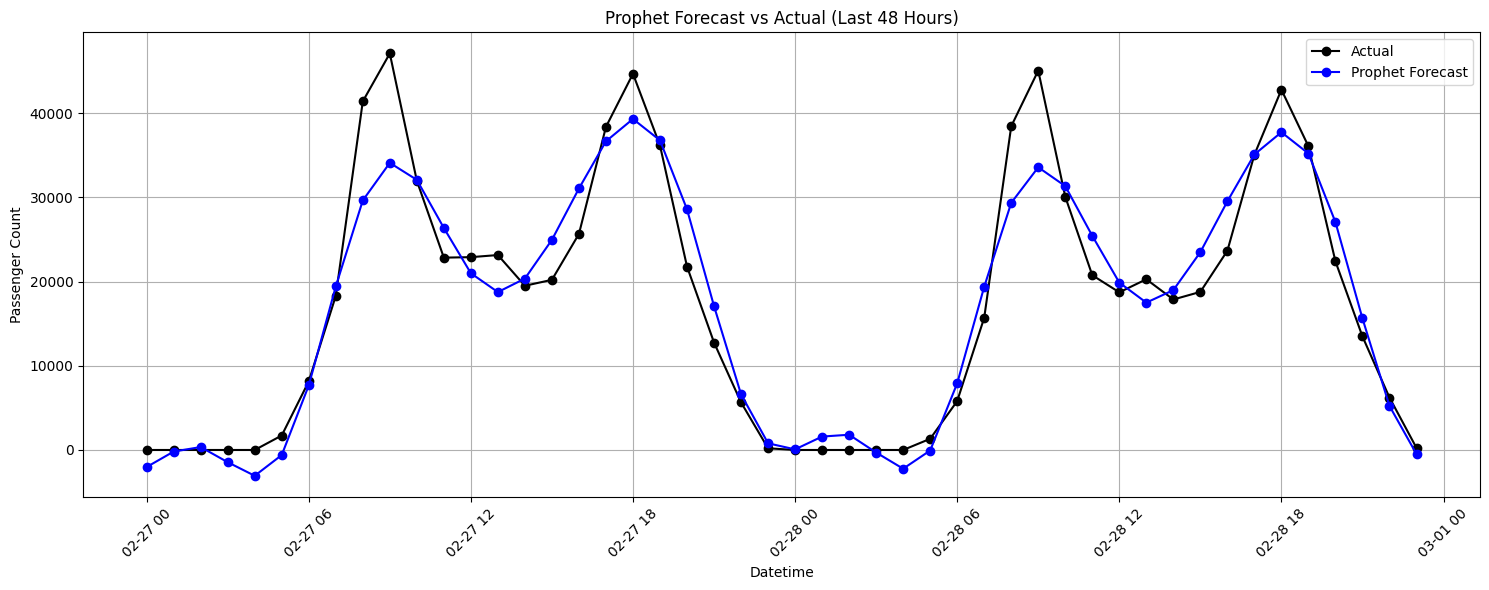

In [31]:
# Replot with aligned actual + predicted values
plt.figure(figsize=(15, 6))
plt.plot(aligned["Datetime"], aligned["Actual"], label="Actual", color="black", marker='o')
plt.plot(aligned["Datetime"], aligned["Predicted"], label="Prophet Forecast", color="blue", marker='o')
plt.title("Prophet Forecast vs Actual (Last 48 Hours)")
plt.xlabel("Datetime")
plt.ylabel("Passenger Count")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


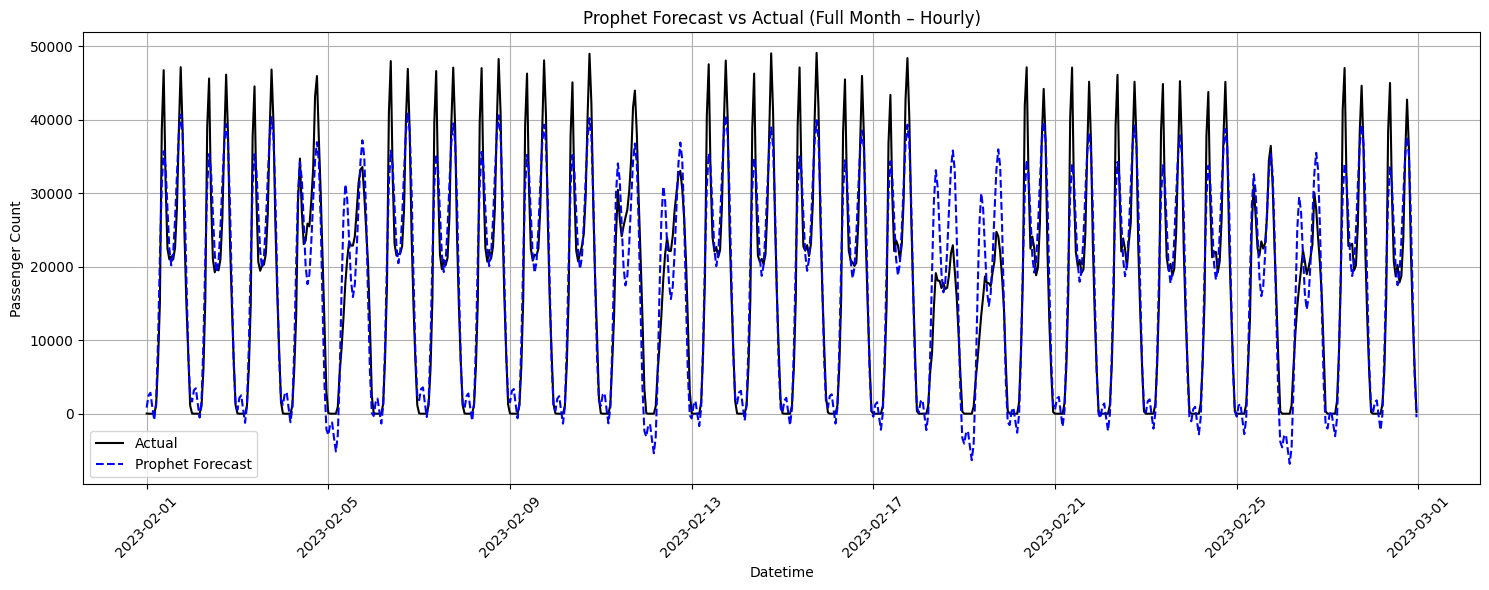

In [32]:
# Join Prophet predictions with actual hourly data
full_month_df = forecast.set_index("ds").join(hourly_df, how='inner')
full_month_df = full_month_df[["yhat", "Ridership"]].dropna().reset_index()
full_month_df.columns = ["Datetime", "Predicted", "Actual"]

# Plot full month
plt.figure(figsize=(15, 6))
plt.plot(full_month_df["Datetime"], full_month_df["Actual"], label="Actual", color="black")
plt.plot(full_month_df["Datetime"], full_month_df["Predicted"], label="Prophet Forecast", color="blue", linestyle='--')
plt.title("Prophet Forecast vs Actual (Full Month – Hourly)")
plt.xlabel("Datetime")
plt.ylabel("Passenger Count")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [33]:
# Example target date (string)
target_date = "2023-02-15"

# Convert to datetime range for that day
start_dt = pd.to_datetime(target_date)
end_dt = start_dt + pd.Timedelta(days=1)

# Extract forecast rows for that date
day_forecast = forecast[(forecast['ds'] >= start_dt) & (forecast['ds'] < end_dt)][['ds', 'yhat']]
day_forecast.columns = ['Datetime', 'Predicted']


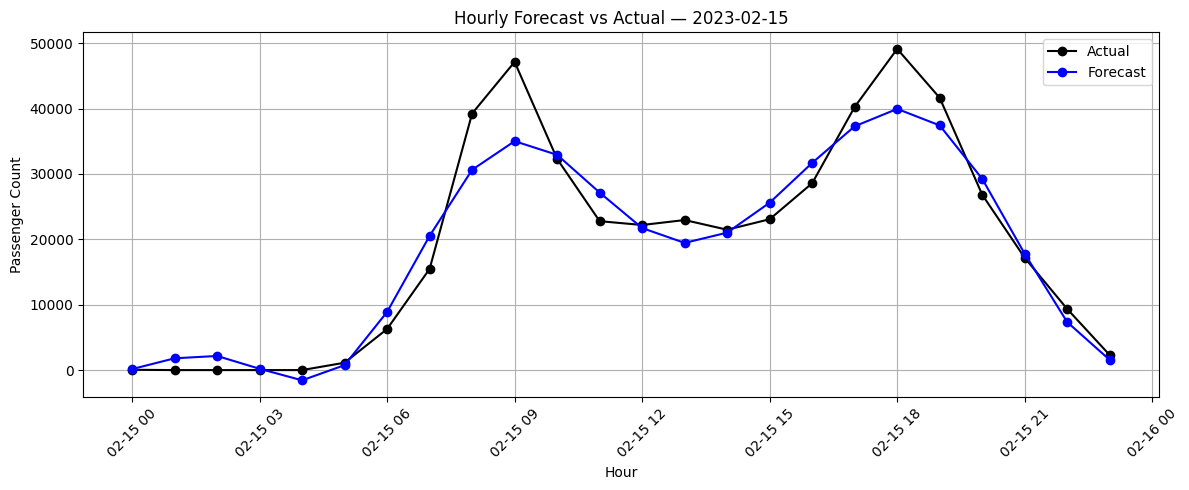

In [34]:
# Optional: compare with actuals if you want
day_actual = hourly_df[(hourly_df.index >= start_dt) & (hourly_df.index < end_dt)]
day_actual = day_actual.reset_index().rename(columns={'Datetime': 'Datetime', 'Ridership': 'Actual'})

# Merge actual + predicted (optional, else use just predicted)
merged_day = pd.merge(day_actual, day_forecast, on='Datetime', how='outer')

# Plot
plt.figure(figsize=(12, 5))
plt.plot(merged_day["Datetime"], merged_day["Actual"], label="Actual", color="black", marker='o')
plt.plot(merged_day["Datetime"], merged_day["Predicted"], label="Forecast", color="blue", marker='o')
plt.title(f"Hourly Forecast vs Actual — {target_date}")
plt.xlabel("Hour")
plt.ylabel("Passenger Count")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [35]:
# 1. Extract only relevant columns from forecast
forecast_df = forecast[["ds", "yhat"]].copy()

# 2. Convert to date and group by day
forecast_df["date"] = forecast_df["ds"].dt.date
daily_forecast = forecast_df.groupby("date")["yhat"].sum().reset_index()
daily_forecast.columns = ["Date", "Predicted Passenger Count"]

# 3. Filter for last week of February (Feb 22–28)
mask = (daily_forecast["Date"] >= pd.to_datetime("2023-02-22").date()) & \
       (daily_forecast["Date"] <= pd.to_datetime("2023-02-28").date())

last_week_forecast = daily_forecast[mask]

# 4. Print results
print("📅 Prophet Forecast – Total Daily Passengers (Feb 22–28):")
print(last_week_forecast.to_string(index=False))


📅 Prophet Forecast – Total Daily Passengers (Feb 22–28):
      Date  Predicted Passenger Count
2023-02-22              431092.080201
2023-02-23              417285.465675
2023-02-24              419553.270404
2023-02-25              376279.575143
2023-02-26              332529.482799
2023-02-27              424029.586008
2023-02-28              412554.892267


In [36]:
# ================================================
# ✅ REBUILD HOURLY DATAFRAME PROPERLY (Datetime)
# ================================================

import pandas as pd

# Load raw data again
df = pd.read_csv("/content/02_2023.csv")

# Convert to full datetime (ensure correct formats!)
df["Datetime"] = pd.to_datetime(df["Entry Date"], format="%d-%m-%Y") + pd.to_timedelta(df["Entry Hour"], unit='h')

# Group by hourly timestamp
hourly_df = df.groupby("Datetime")["Entry Count"].sum().reset_index()

# Rename and set index
hourly_df = hourly_df.rename(columns={"Entry Count": "Total_Ridership"})
hourly_df = hourly_df.set_index("Datetime")

# Optional: Fill missing hours (ensure hourly continuity)
hourly_df = hourly_df.asfreq("H")
hourly_df["Total_Ridership"] = hourly_df["Total_Ridership"].ffill()  # or .fillna(0)

# Check new range
print("✅ Hourly data rebuilt successfully")
print("Start:", hourly_df.index.min())
print("End:", hourly_df.index.max())


✅ Hourly data rebuilt successfully
Start: 2023-02-01 00:00:00
End: 2023-02-28 23:00:00


<ipython-input-36-e7af8937017d>:21: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_df = hourly_df.asfreq("H")


<ipython-input-37-e82df39924f9>:26: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  day_forecast["Datetime"] = pd.to_datetime(day_forecast["Datetime"]).dt.round("H")
<ipython-input-37-e82df39924f9>:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  day_actual["Datetime"] = pd.to_datetime(day_actual["Datetime"]).dt.round("H")


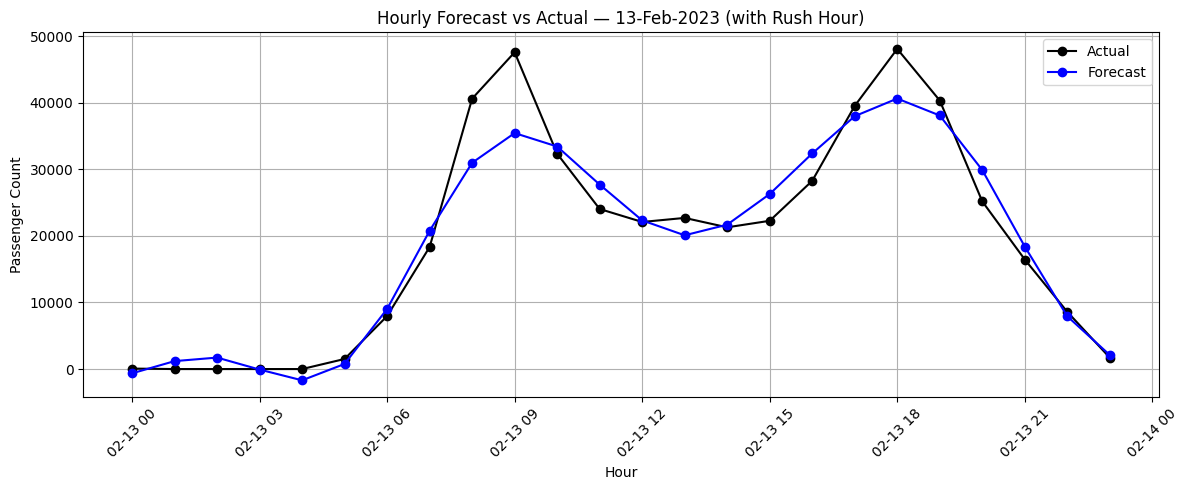

In [37]:
# ========================================================
# 📅 HOURLY ANALYSIS: Prophet Forecast vs Actual (13-Feb)
# ========================================================

import matplotlib.pyplot as plt
import pandas as pd

# ✅ Step 0: Ensure hourly_df is clean and datetime-indexed
hourly_df.index = pd.to_datetime(hourly_df.index)

# ✅ Step 1: Pick the date you want to analyze
target_date = "2023-02-13"
start_dt = pd.to_datetime(target_date)
end_dt = start_dt + pd.Timedelta(days=1)

# ✅ Step 2: Extract forecast rows for that date
day_forecast = forecast[(forecast['ds'] >= start_dt) & (forecast['ds'] < end_dt)][['ds', 'yhat']]
day_forecast.columns = ['Datetime', 'Predicted']

# ✅ Step 3: Extract actuals for the same date
day_actual = hourly_df[(hourly_df.index >= start_dt) & (hourly_df.index < end_dt)].copy()
day_actual = day_actual.rename(columns={"Total_Ridership": "Actual"})
day_actual = day_actual.reset_index()

# ✅ Step 4: Round timestamps to ensure exact match
day_forecast["Datetime"] = pd.to_datetime(day_forecast["Datetime"]).dt.round("H")
day_actual["Datetime"] = pd.to_datetime(day_actual["Datetime"]).dt.round("H")

# ✅ Step 5: Merge forecast and actual
merged_day = pd.merge(day_actual, day_forecast, on="Datetime", how="outer")

# ✅ Step 6: Plot
plt.figure(figsize=(12, 5))
plt.plot(merged_day["Datetime"], merged_day["Actual"], label="Actual", color="black", marker='o')
plt.plot(merged_day["Datetime"], merged_day["Predicted"], label="Forecast", color="blue", marker='o')
plt.title("Hourly Forecast vs Actual — 13-Feb-2023 (with Rush Hour)")
plt.xlabel("Hour")
plt.ylabel("Passenger Count")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [38]:
# ================================================
# ✅ TRAIN PROPHET ON HOURLY RIDERSHIP DATA
# ================================================

from prophet import Prophet

# Step 1: Add rush hour flag
hourly_df["is_rush_hour"] = hourly_df.index.hour.isin([7,8,9,17,18,19]).astype(int)

# Step 2: Prepare Prophet dataframe
prophet_hourly_df = hourly_df.reset_index()
prophet_hourly_df.columns = ['ds', 'y', 'is_rush_hour']  # Prophet expects ds & y

# Step 3: Initialize and train model
model = Prophet(daily_seasonality=False, weekly_seasonality=True)
model.add_regressor('is_rush_hour')
model.fit(prophet_hourly_df)

# Step 4: Create future dataframe for 48 hours
future = model.make_future_dataframe(periods=48, freq='h')
future["is_rush_hour"] = future["ds"].dt.hour.isin([7,8,9,17,18,19]).astype(int)

# Step 5: Predict
forecast = model.predict(future)
forecast["yhat"] = forecast["yhat"].clip(lower=0)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4bepnurc/gd9_l6hw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4bepnurc/5ps9rp3c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2021', 'data', 'file=/tmp/tmp4bepnurc/gd9_l6hw.json', 'init=/tmp/tmp4bepnurc/5ps9rp3c.json', 'output', 'file=/tmp/tmp4bepnurc/prophet_modelfheapjq5/prophet_model-20250521205554.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:55:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:55:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


<ipython-input-39-e82df39924f9>:26: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  day_forecast["Datetime"] = pd.to_datetime(day_forecast["Datetime"]).dt.round("H")
<ipython-input-39-e82df39924f9>:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  day_actual["Datetime"] = pd.to_datetime(day_actual["Datetime"]).dt.round("H")


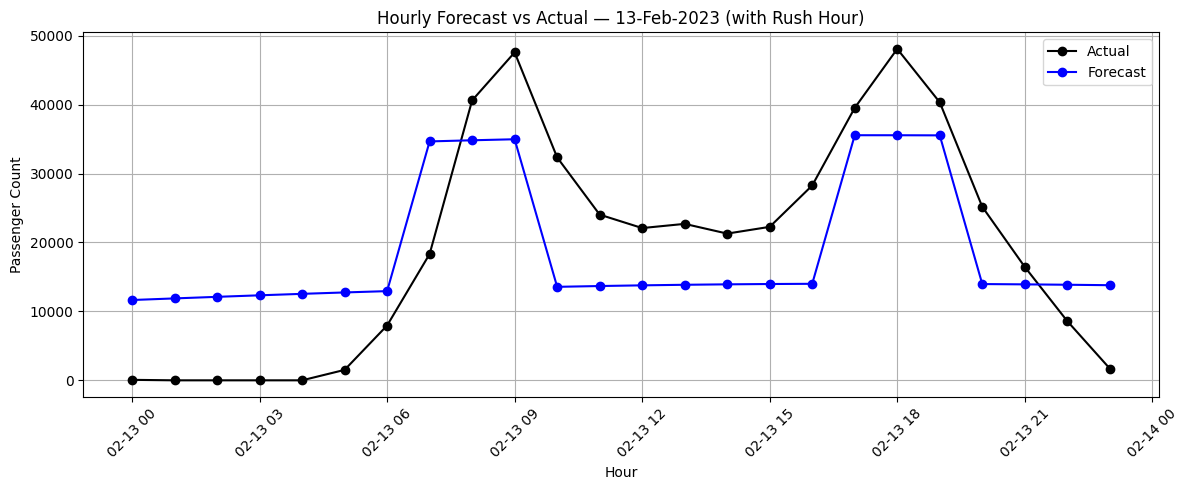

In [39]:
# ========================================================
# 📅 HOURLY ANALYSIS: Prophet Forecast vs Actual (13-Feb)
# ========================================================

import matplotlib.pyplot as plt
import pandas as pd

# ✅ Step 0: Ensure hourly_df is clean and datetime-indexed
hourly_df.index = pd.to_datetime(hourly_df.index)

# ✅ Step 1: Pick the date you want to analyze
target_date = "2023-02-13"
start_dt = pd.to_datetime(target_date)
end_dt = start_dt + pd.Timedelta(days=1)

# ✅ Step 2: Extract forecast rows for that date
day_forecast = forecast[(forecast['ds'] >= start_dt) & (forecast['ds'] < end_dt)][['ds', 'yhat']]
day_forecast.columns = ['Datetime', 'Predicted']

# ✅ Step 3: Extract actuals for the same date
day_actual = hourly_df[(hourly_df.index >= start_dt) & (hourly_df.index < end_dt)].copy()
day_actual = day_actual.rename(columns={"Total_Ridership": "Actual"})
day_actual = day_actual.reset_index()

# ✅ Step 4: Round timestamps to ensure exact match
day_forecast["Datetime"] = pd.to_datetime(day_forecast["Datetime"]).dt.round("H")
day_actual["Datetime"] = pd.to_datetime(day_actual["Datetime"]).dt.round("H")

# ✅ Step 5: Merge forecast and actual
merged_day = pd.merge(day_actual, day_forecast, on="Datetime", how="outer")

# ✅ Step 6: Plot
plt.figure(figsize=(12, 5))
plt.plot(merged_day["Datetime"], merged_day["Actual"], label="Actual", color="black", marker='o')
plt.plot(merged_day["Datetime"], merged_day["Predicted"], label="Forecast", color="blue", marker='o')
plt.title("Hourly Forecast vs Actual — 13-Feb-2023 (with Rush Hour)")
plt.xlabel("Hour")
plt.ylabel("Passenger Count")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4bepnurc/u8ufvd5f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4bepnurc/m3ljucw8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30956', 'data', 'file=/tmp/tmp4bepnurc/u8ufvd5f.json', 'init=/tmp/tmp4bepnurc/m3ljucw8.json', 'output', 'file=/tmp/tmp4bepnurc/prophet_modelic0vptf0/prophet_model-20250521205556.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:55:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:55:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version

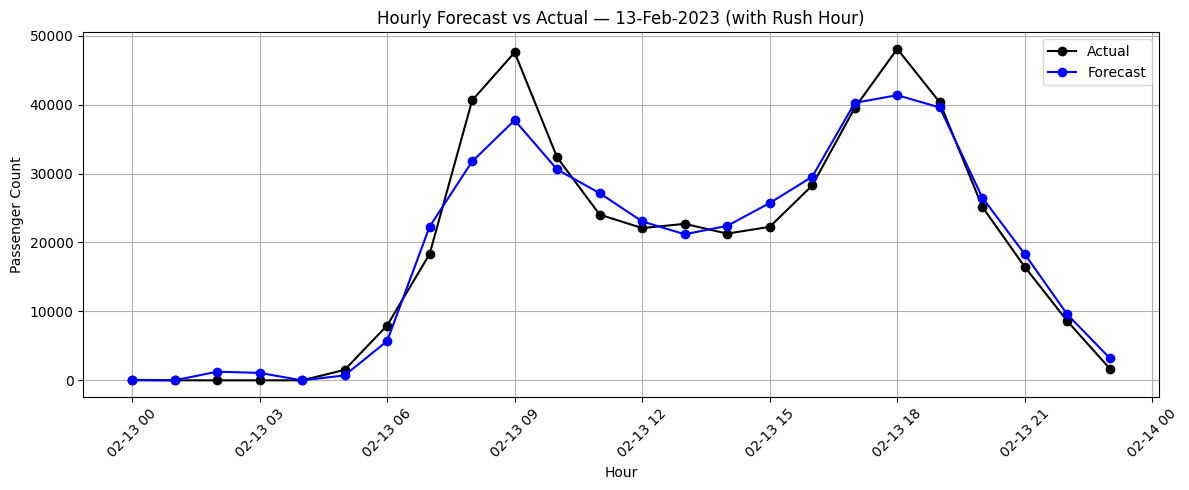

In [40]:
# Rebuild Prophet-ready dataframe
prophet_hourly_df = hourly_df.reset_index()
prophet_hourly_df.columns = ['ds', 'y', 'is_rush_hour']

# Train model
from prophet import Prophet
model = Prophet(daily_seasonality=True, weekly_seasonality=True)
model.add_regressor('is_rush_hour')
model.fit(prophet_hourly_df)

# Forecast
future = model.make_future_dataframe(periods=48, freq='H')
future['is_rush_hour'] = future['ds'].dt.hour.isin([7,8,9,17,18,19]).astype(int)
forecast = model.predict(future)
forecast['yhat'] = forecast['yhat'].clip(lower=0)

target_date = "2023-02-13"
start_dt = pd.to_datetime(target_date)
end_dt = start_dt + pd.Timedelta(days=1)

day_forecast = forecast[(forecast['ds'] >= start_dt) & (forecast['ds'] < end_dt)][['ds', 'yhat']]
day_forecast.columns = ['Datetime', 'Predicted']

day_actual = hourly_df[(hourly_df.index >= start_dt) & (hourly_df.index < end_dt)].copy()
day_actual = day_actual.rename(columns={"Total_Ridership": "Actual"}).reset_index()

merged_day = pd.merge(day_actual, day_forecast, on="Datetime", how="outer")

plt.figure(figsize=(12, 5))
plt.plot(merged_day["Datetime"], merged_day["Actual"], label="Actual", color="black", marker='o')
plt.plot(merged_day["Datetime"], merged_day["Predicted"], label="Forecast", color="blue", marker='o')
plt.title("Hourly Forecast vs Actual — 13-Feb-2023 (with Rush Hour)")
plt.xlabel("Hour")
plt.ylabel("Passenger Count")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


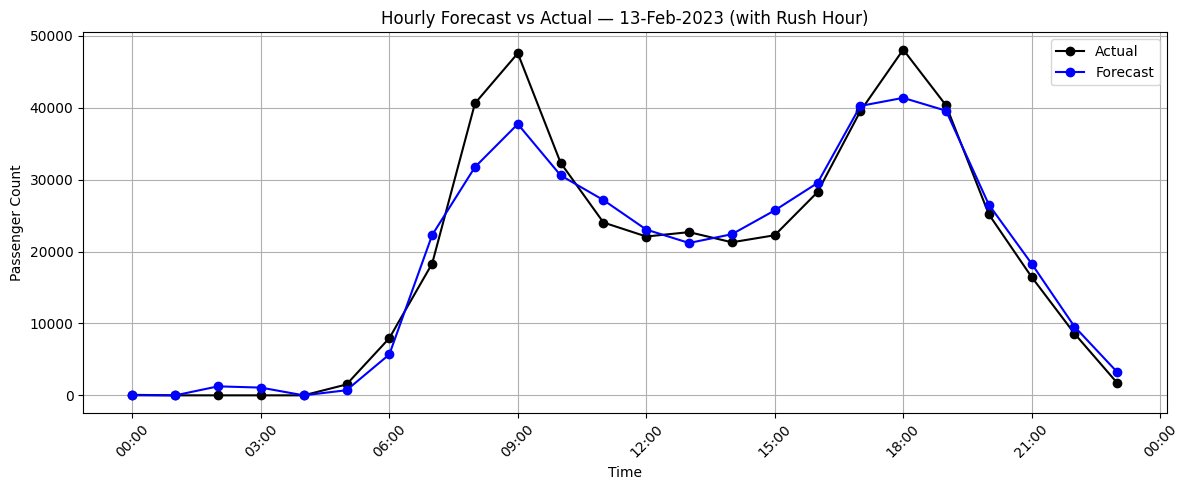

In [41]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(12, 5))
plt.plot(merged_day["Datetime"], merged_day["Actual"], label="Actual", color="black", marker='o')
plt.plot(merged_day["Datetime"], merged_day["Predicted"], label="Forecast", color="blue", marker='o')
plt.title("Hourly Forecast vs Actual — 13-Feb-2023 (with Rush Hour)")
plt.xlabel("Time")
plt.ylabel("Passenger Count")
plt.xticks(rotation=45)

# 🕒 Set x-axis format to only show HH:MM
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [42]:
weather_df = pd.read_csv("weather_feb2023.csv")
weather_df["Datetime"] = pd.to_datetime(weather_df["Datetime"])
weather_df = weather_df.set_index("Datetime").asfreq("H")


<ipython-input-42-1c6edfb121bd>:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  weather_df = weather_df.set_index("Datetime").asfreq("H")


In [43]:
import pandas as pd

# Load weather data
weather_df = pd.read_csv("weather_feb2023.csv")

# Convert 'Datetime' column to datetime type
weather_df["Datetime"] = pd.to_datetime(weather_df["Datetime"])

# Set 'Datetime' as index and resample to hourly frequency using lowercase 'h'
weather_df = weather_df.set_index("Datetime").asfreq("h")

# Optional: Preview the data
weather_df.head()


,Temperature,Humidity,Condition
Datetime,,,
2023-02-01 00:00:00,19.3,58,Clear
2023-02-01 01:00:00,19.3,60,Clear
2023-02-01 02:00:00,18.2,59,Clear
2023-02-01 03:00:00,16.0,69,Clear
2023-02-01 04:00:00,18.1,63,Clear


In [44]:
# Merge weather data with metro ridership data
merged_df = hourly_df.merge(weather_df, how="left", left_index=True, right_index=True)

# Preview the merged DataFrame
merged_df.head()


,Total_Ridership,is_rush_hour,Temperature,Humidity,Condition
Datetime,,,,,
2023-02-01 00:00:00,22.0,0,19.3,58,Clear
2023-02-01 01:00:00,0.0,0,19.3,60,Clear
2023-02-01 02:00:00,0.0,0,18.2,59,Clear
2023-02-01 03:00:00,0.0,0,16.0,69,Clear
2023-02-01 04:00:00,0.0,0,18.1,63,Clear


In [45]:
# Fill any missing weather values (optional and depends on your dataset)
merged_df["Temperature"] = merged_df["Temperature"].interpolate()
merged_df["Humidity"] = merged_df["Humidity"].interpolate()
merged_df["Condition"] = merged_df["Condition"].ffill()


In [46]:
df_prophet = merged_df.reset_index().rename(columns={"Datetime": "ds", "Total_Ridership": "y"})
# One-hot encode 'Condition'
condition_dummies = pd.get_dummies(df_prophet["Condition"], prefix="Condition")
df_prophet = pd.concat([df_prophet, condition_dummies], axis=1)
df_prophet.drop("Condition", axis=1, inplace=True)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4bepnurc/0k5fwn3r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4bepnurc/28u088r8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67229', 'data', 'file=/tmp/tmp4bepnurc/0k5fwn3r.json', 'init=/tmp/tmp4bepnurc/28u088r8.json', 'output', 'file=/tmp/tmp4bepnurc/prophet_model5371h4bt/prophet_model-20250521205558.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:55:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:55:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


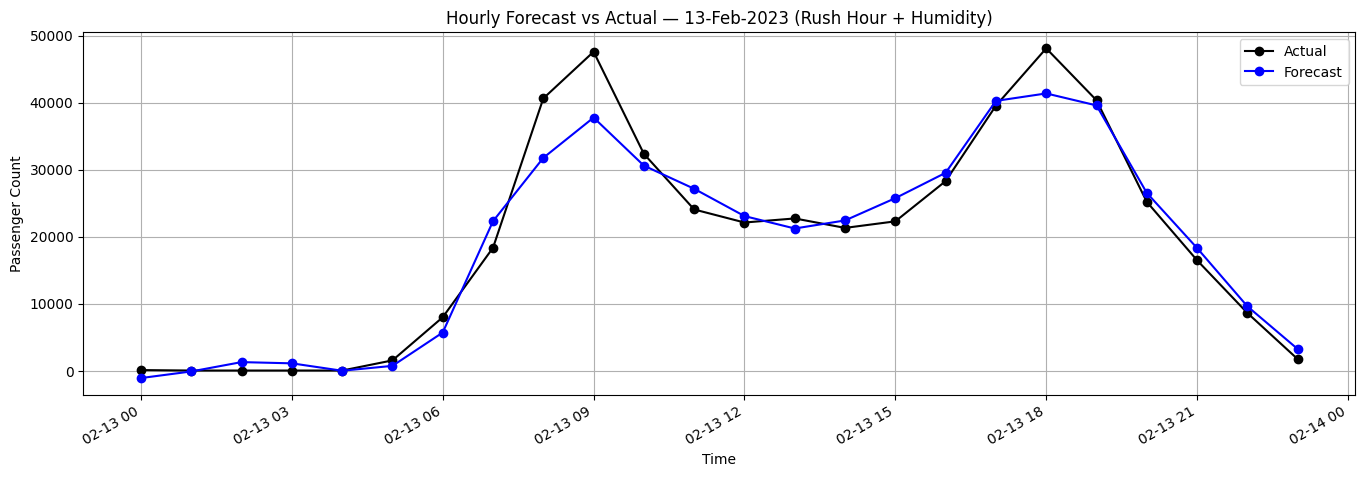

In [47]:
from prophet import Prophet

# Initialize model
model = Prophet()
model.add_regressor("is_rush_hour")
model.add_regressor("Humidity")

# Fit the model
model.fit(df_prophet)

# No future dates — just use existing data
future = df_prophet[["ds", "is_rush_hour", "Humidity"]]
forecast = model.predict(future)

import matplotlib.pyplot as plt

# Filter for 13-Feb-2023
actual_day = df_prophet[df_prophet["ds"].dt.date == pd.to_datetime("2023-02-13").date()]
forecast_day = forecast[forecast["ds"].dt.date == pd.to_datetime("2023-02-13").date()]

# Plot
plt.figure(figsize=(14, 5))
plt.plot(actual_day["ds"], actual_day["y"], marker='o', color='black', label="Actual")
plt.plot(forecast_day["ds"], forecast_day["yhat"], marker='o', color='blue', label="Forecast")

plt.title("Hourly Forecast vs Actual — 13-Feb-2023 (Rush Hour + Humidity)")
plt.xlabel("Time")
plt.ylabel("Passenger Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.gcf().autofmt_xdate()  # Auto-format x-axis labels
plt.show()


In [48]:
model_a = Prophet()
model_a.add_regressor("is_rush_hour")
model_a.fit(df_prophet[["ds", "y", "is_rush_hour"]])
forecast_a = model_a.predict(df_prophet[["ds", "is_rush_hour"]])


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4bepnurc/shaqc2bi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4bepnurc/nm3c1_h0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94254', 'data', 'file=/tmp/tmp4bepnurc/shaqc2bi.json', 'init=/tmp/tmp4bepnurc/nm3c1_h0.json', 'output', 'file=/tmp/tmp4bepnurc/prophet_model0u_77csp/prophet_model-20250521205559.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:55:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:55:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [49]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Filter actuals
y_true = df_prophet[df_prophet["ds"].dt.date == pd.to_datetime("2023-02-13").date()]["y"].values

# Forecasts
y_pred_a = forecast_a[forecast_a["ds"].dt.date == pd.to_datetime("2023-02-13").date()]["yhat"].values
y_pred_b = forecast[forecast["ds"].dt.date == pd.to_datetime("2023-02-13").date()]["yhat"].values

# Metrics
mae_a = mean_absolute_error(y_true, y_pred_a)
mae_b = mean_absolute_error(y_true, y_pred_b)

rmse_a = np.sqrt(mean_squared_error(y_true, y_pred_a))
rmse_b = np.sqrt(mean_squared_error(y_true, y_pred_b))

print(f"Model A (Rush only)  → MAE: {mae_a:.2f}, RMSE: {rmse_a:.2f}")
print(f"Model B (Rush + Hum) → MAE: {mae_b:.2f}, RMSE: {rmse_b:.2f}")


Model A (Rush only)  → MAE: 2351.63, RMSE: 3454.66
Model B (Rush + Hum) → MAE: 2351.37, RMSE: 3453.58


<ipython-input-52-8090776b0a98>:36: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


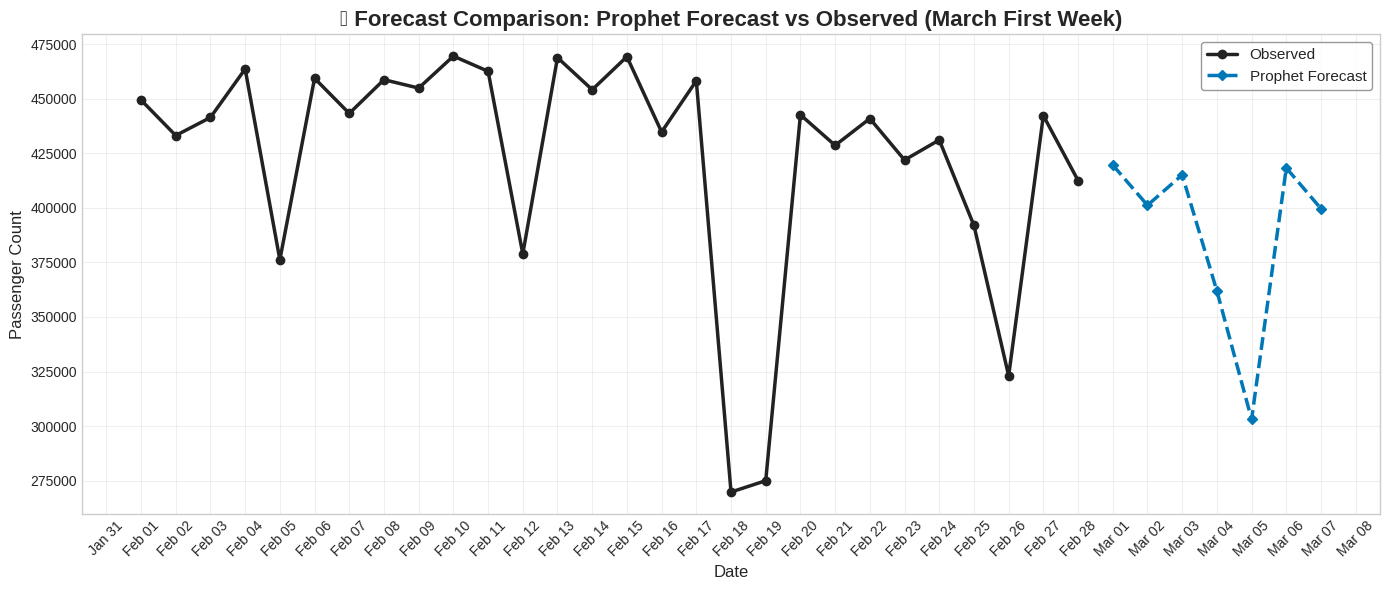

In [52]:
# ================================================
# 🎨 Beautiful Plot: Prophet Forecast vs Observed
# ================================================
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.style.use("seaborn-v0_8-whitegrid")  # Clean modern style

# Create the figure
plt.figure(figsize=(14, 6))

# Plot observed values
plt.plot(combined['Date'], combined['Actual'],
         label='Observed', color='#222222', linewidth=2.5, marker='o', markersize=6)

# Plot Prophet forecast
plt.plot(combined['Date'], combined['Predicted'],
         label='Prophet Forecast', color='#0077b6', linestyle='--', linewidth=2.5, marker='D', markersize=5)

# Title and labels
plt.title('📈 Forecast Comparison: Prophet Forecast vs Observed (March First Week)',
          fontsize=16, weight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Passenger Count', fontsize=12)
plt.xticks(rotation=45)

# Date formatting for x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())

# Grid and legend
plt.grid(True, alpha=0.3)
plt.legend(loc="upper right", fontsize=11, frameon=True, facecolor='white', edgecolor='gray')

# Final layout
plt.tight_layout()
plt.show()


<ipython-input-53-7c955e081779>:46: UserWarning: Glyph 11014 (\N{UPWARDS BLACK ARROW}) missing from font(s) Liberation Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust for title/subtitle space
<ipython-input-53-7c955e081779>:46: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Liberation Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust for title/subtitle space
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 11014 (\N{UPWARDS BLACK ARROW}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


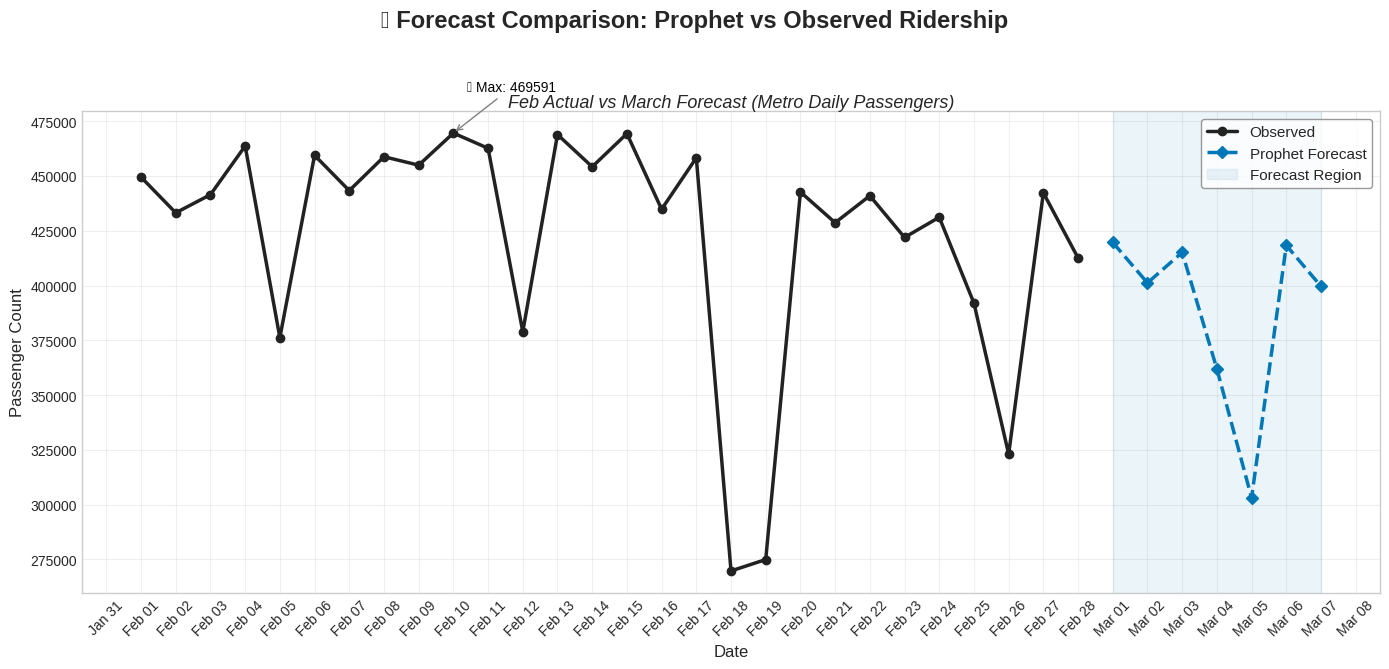

In [53]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.style.use("seaborn-v0_8-whitegrid")

fig, ax = plt.subplots(figsize=(14, 7))

# Observed (Feb)
ax.plot(combined['Date'], combined['Actual'],
        label='Observed', color='#222222', linewidth=2.5, marker='o', markersize=6)

# Forecast (March 1–7)
ax.plot(combined['Date'], combined['Predicted'],
        label='Prophet Forecast', color='#0077b6', linestyle='--', linewidth=2.5, marker='D', markersize=6)

# Highlight March region
start_march = pd.to_datetime("2023-03-01")
end_march = pd.to_datetime("2023-03-07")
ax.axvspan(start_march, end_march, color="#0077b6", alpha=0.08, label="Forecast Region")

# Title & subtitle
plt.suptitle("📊 Forecast Comparison: Prophet vs Observed Ridership", fontsize=17, weight='bold')
plt.title("Feb Actual vs March Forecast (Metro Daily Passengers)", fontsize=13, style='italic', pad=2)

# Axis labels
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Passenger Count", fontsize=12)

# Date formatting
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.xaxis.set_major_locator(mdates.DayLocator())
plt.xticks(rotation=45)

# Annotate max value in observed
max_val = combined['Actual'].max()
max_date = combined[combined['Actual'] == max_val]['Date'].values[0]
ax.annotate(f'⬆ Max: {int(max_val)}',
            xy=(max_date, max_val), xytext=(10, 30),
            textcoords='offset points',
            arrowprops=dict(arrowstyle='->', color='gray'),
            fontsize=10, color='black')

# Grid, legend, layout
plt.grid(True, alpha=0.3)
plt.legend(loc="upper right", fontsize=11, frameon=True, facecolor='white', edgecolor='gray')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust for title/subtitle space

plt.show()


<ipython-input-54-682d017f2054>:43: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Liberation Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
<ipython-input-54-682d017f2054>:44: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Liberation Sans.
  plt.savefig("prophet_forecast_vs_observed.png", dpi=300, bbox_inches='tight')
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


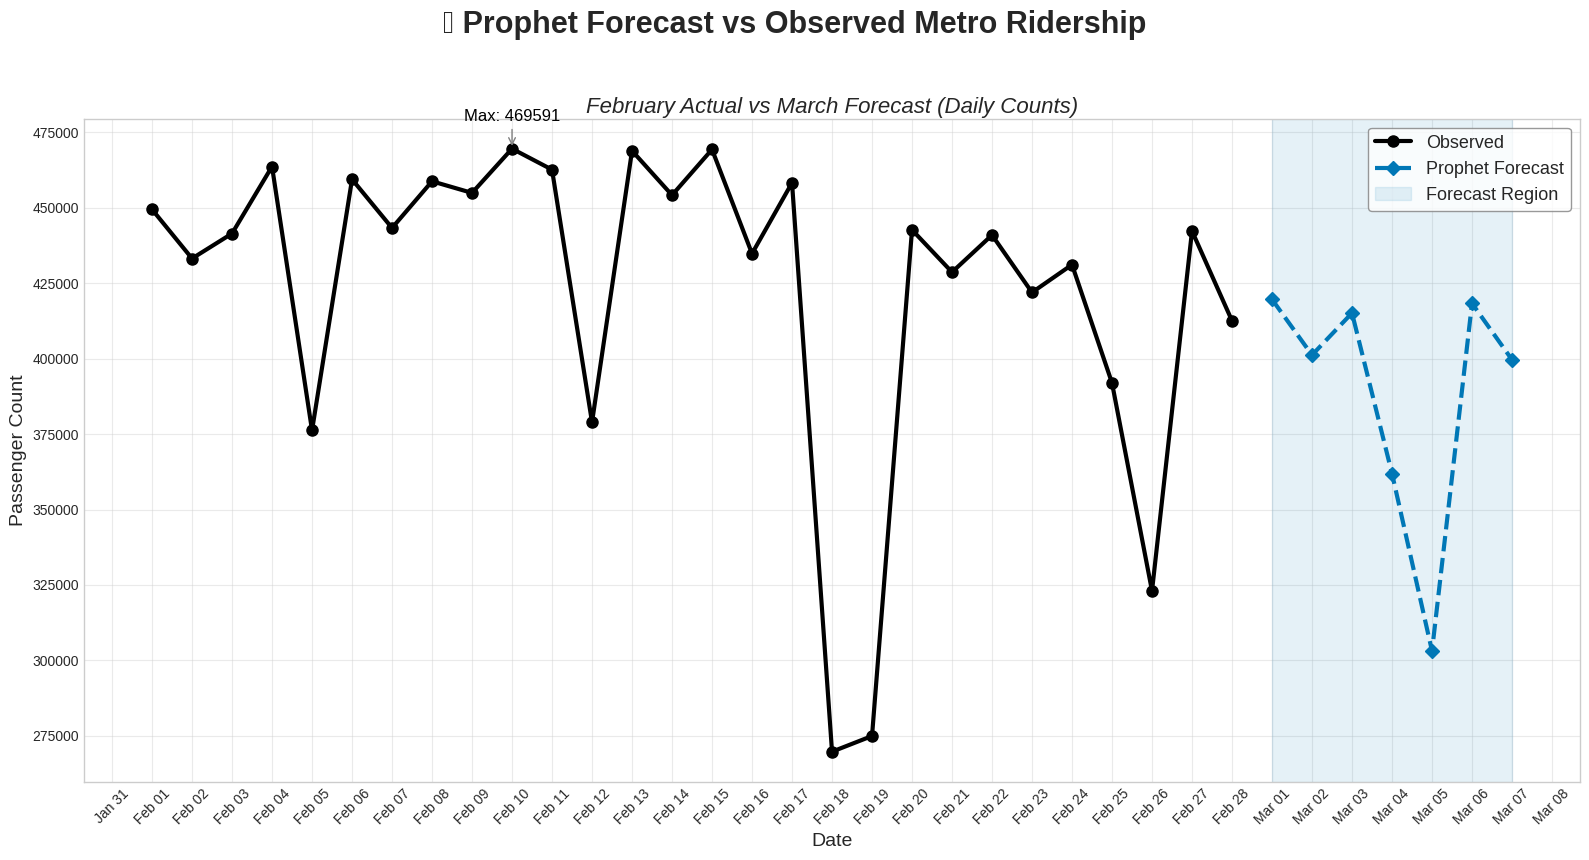

In [54]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(16, 9))  # Wider for poster

# Plot Observed
ax.plot(combined['Date'], combined['Actual'],
        label='Observed', color='black', linewidth=3, marker='o', markersize=8)

# Plot Forecast
ax.plot(combined['Date'], combined['Predicted'],
        label='Prophet Forecast', color='#0077b6', linestyle='--', linewidth=3, marker='D', markersize=7)

# Highlight forecast region
ax.axvspan(pd.to_datetime("2023-03-01"), pd.to_datetime("2023-03-07"),
           color='#0077b6', alpha=0.1, label='Forecast Region')

# Titles and labels
plt.suptitle("📊 Prophet Forecast vs Observed Metro Ridership", fontsize=22, weight='bold')
plt.title("February Actual vs March Forecast (Daily Counts)", fontsize=16, style='italic', pad=4)
ax.set_xlabel("Date", fontsize=14)
ax.set_ylabel("Passenger Count", fontsize=14)

# Date format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.xticks(rotation=45)

# Annotate max
max_val = combined['Actual'].max()
max_date = combined[combined['Actual'] == max_val]['Date'].values[0]
ax.annotate(f'Max: {int(max_val)}', xy=(max_date, max_val),
            xytext=(0, 20), textcoords='offset points',
            ha='center', fontsize=12, color='black',
            arrowprops=dict(arrowstyle='->', color='gray'))

# Grid and legend
plt.grid(True, alpha=0.4)
plt.legend(loc='upper right', fontsize=13, frameon=True, facecolor='white', edgecolor='gray')

# Save high-resolution image
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("prophet_forecast_vs_observed.png", dpi=300, bbox_inches='tight')
plt.show()


In [55]:
import plotly.graph_objects as go

fig = go.Figure()

# Actual
fig.add_trace(go.Scatter(
    x=combined['Date'], y=combined['Actual'],
    mode='lines+markers',
    name='Observed',
    line=dict(color='black', width=2.5),
    marker=dict(size=7)
))

# Forecast
fig.add_trace(go.Scatter(
    x=combined['Date'], y=combined['Predicted'],
    mode='lines+markers',
    name='Prophet Forecast',
    line=dict(color='blue', dash='dash', width=2.5),
    marker=dict(symbol='diamond', size=7)
))

# Layout with forecast region
fig.add_vrect(
    x0="2023-03-01", x1="2023-03-07",
    fillcolor="lightblue", opacity=0.3,
    layer="below", line_width=0, annotation_text="Forecast Region", annotation_position="top left"
)

fig.update_layout(
    title="📊 Forecast vs Observed Ridership<br><sup>With Interactive Hover & Zoom</sup>",
    xaxis_title="Date",
    yaxis_title="Passenger Count",
    template="plotly_white",
    legend=dict(bordercolor="gray", borderwidth=1)
)

fig.show()


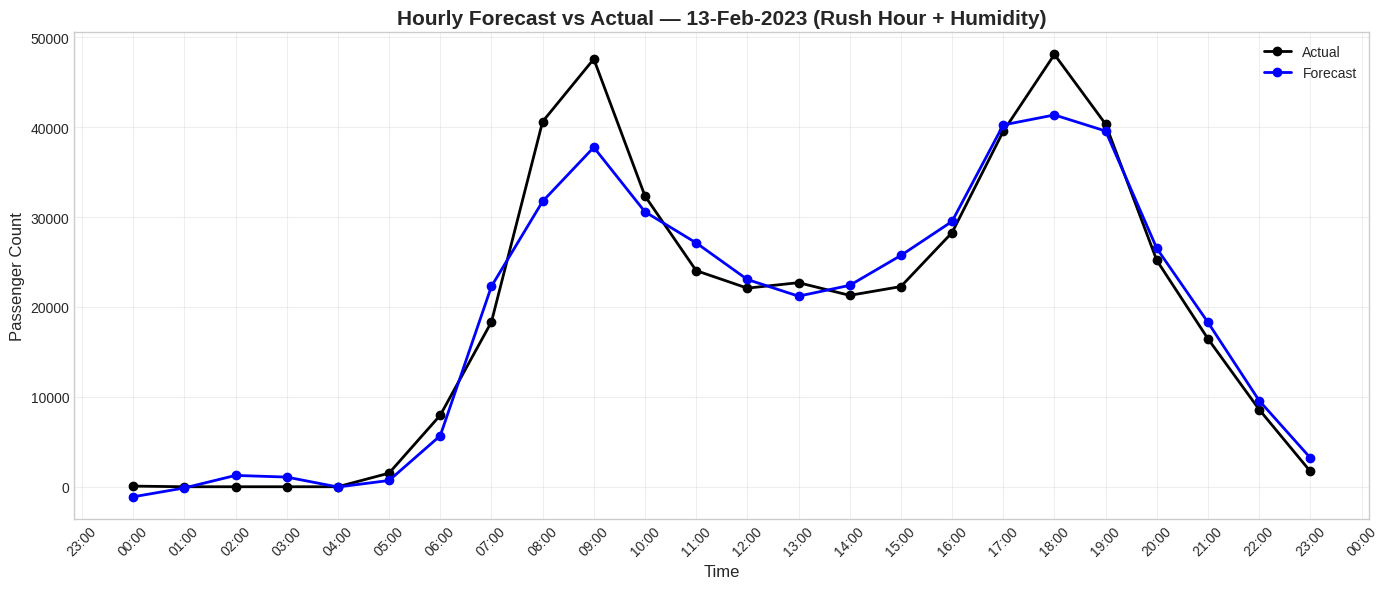

In [56]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Plot
plt.figure(figsize=(14, 6))
plt.plot(actual_day["ds"], actual_day["y"], marker='o', color='black', label="Actual", linewidth=2)
plt.plot(forecast_day["ds"], forecast_day["yhat"], marker='o', color='blue', label="Forecast", linewidth=2)

# Title & labels
plt.title("Hourly Forecast vs Actual — 13-Feb-2023 (Rush Hour + Humidity)", fontsize=15, weight='bold')
plt.xlabel("Time", fontsize=12)
plt.ylabel("Passenger Count", fontsize=12)

# Format x-axis as hourly intervals
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))       # Show every hour
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))      # Format as HH:MM
plt.xticks(rotation=45)

# Legend, grid, layout
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


<ipython-input-65-6fe8063589e7>:40: UserWarning:

Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) Liberation Sans.

<ipython-input-65-6fe8063589e7>:40: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from font(s) Liberation Sans.

<ipython-input-65-6fe8063589e7>:43: UserWarning:

Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) Liberation Sans.

<ipython-input-65-6fe8063589e7>:43: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from font(s) Liberation Sans.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) Liberation Sans.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from font(s) Liberation Sans.



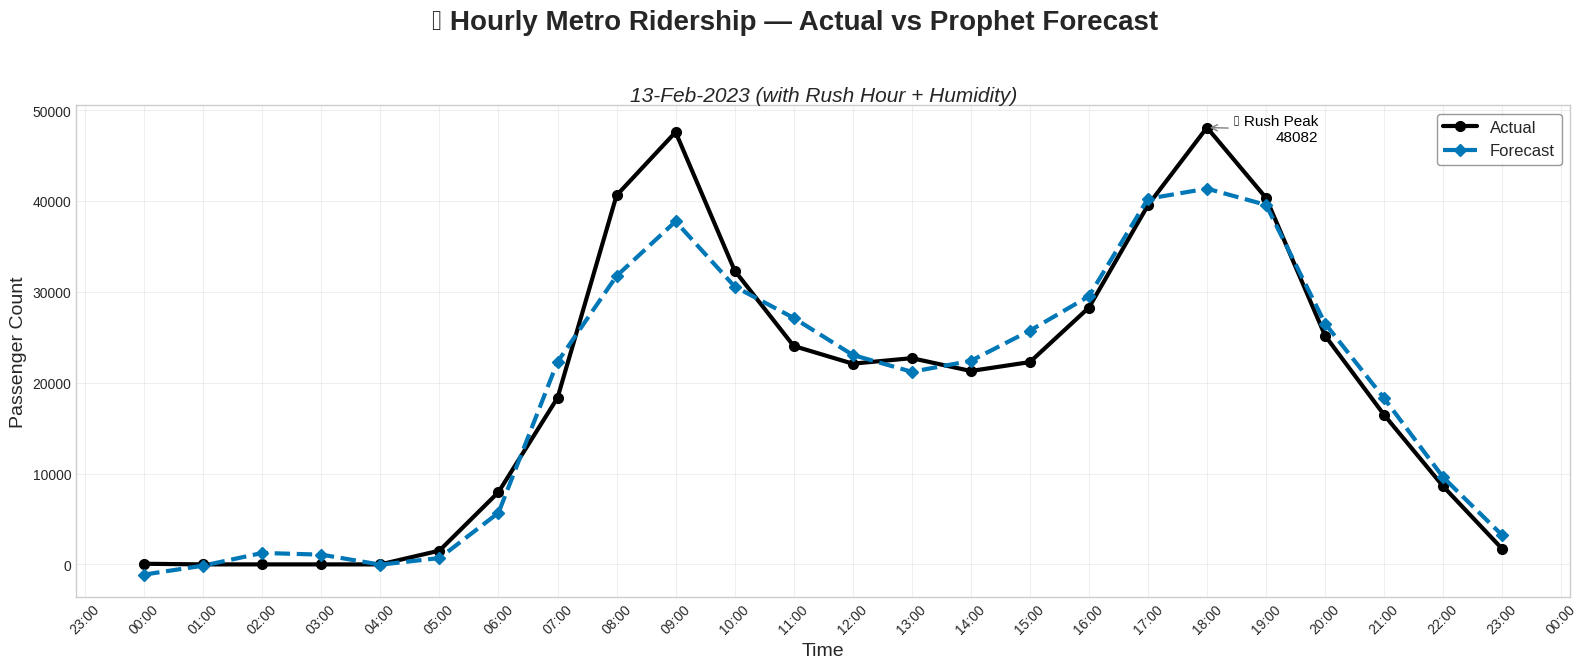

In [65]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(16, 7))

# Actual
ax.plot(actual_day["ds"], actual_day["y"],
        label="Actual", color='black', linewidth=3, marker='o', markersize=7)

# Forecast
ax.plot(forecast_day["ds"], forecast_day["yhat"],
        label="Forecast", color='#0077b6', linestyle='--', linewidth=3, marker='D', markersize=6)

# Titles and labels
plt.suptitle("📊 Hourly Metro Ridership — Actual vs Prophet Forecast", fontsize=20, weight='bold')
plt.title("13-Feb-2023 (with Rush Hour + Humidity)", fontsize=15, style='italic', pad=3)
ax.set_xlabel("Time", fontsize=14)
ax.set_ylabel("Passenger Count", fontsize=14)

# Format x-axis as hourly
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xticks(rotation=45)

# Set the new peak timestamp
peak_time = pd.to_datetime("2023-02-13 18:00:00")
peak_value = 48082  # confirmed value

ax.annotate(f"📍 Rush Peak\n{peak_value}",
            xy=(peak_time, peak_value),
            xytext=(80, -10), textcoords='offset points',
            ha='right',
            fontsize=11, color='black',
            arrowprops=dict(arrowstyle='->', color='gray'))

# Grid, legend, layout
plt.grid(True, alpha=0.3)
plt.legend(loc="upper right", fontsize=12, frameon=True, facecolor='white', edgecolor='gray')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Export at 300 DPI for poster
plt.savefig("hourly_forecast_vs_actual_feb13.png", dpi=300, bbox_inches='tight')
plt.show()
